In [1]:
import numpy as np
import scipy.optimize as op
import datetime
import emcee
import matplotlib.pyplot as plt
import corner
from scipy.stats import norm, halfnorm
%matplotlib inline

In [2]:
mars = np.genfromtxt('harp_mars.dat', usecols=np.arange(0, 9))
jupiter = np.genfromtxt('harp_jupiter.dat', usecols=np.arange(0, 8))
uranus = np.genfromtxt('harp_uranus.dat', usecols=np.arange(0, 8))

In [3]:
mars_etamb = mars[:,5]
jupiter_etamb = jupiter[:,5]
uranus_etamb = uranus[:,5]

mars_dates = mars[:,0]
jupiter_dates = jupiter[:,0]
uranus_dates = uranus[:,0]

mars = mars[mars[:,1] > 5]
mars = mars[mars[:,1] < 19]
mars = mars[mars[:,5] > 0]
jupiter = jupiter[jupiter[:,1] > 5]
jupiter = jupiter[jupiter[:,1] < 19]
jupiter = jupiter[jupiter[:,5] > 0]
uranus = uranus[uranus[:,1] > 5]
uranus = uranus[uranus[:,1] < 19]
uranus = uranus[uranus[:,5] > 0]

planets_etamb = np.concatenate((mars_etamb, jupiter_etamb, uranus_etamb), axis=0)
raw_dates = np.concatenate((mars_dates, jupiter_dates, uranus_dates), axis=0)
dates = [datetime.datetime.strptime(str(int(date)),'%Y%m%d') for date in raw_dates]

In [169]:
oldest = min(dates)
days = np.array([np.float64((date - oldest).days) + 1 for date in dates])
days = days/np.max(days)

In [123]:
m_true = 0.0
b_true = .5

delty1_true = 0.0
delty2_true = 0.3
sigsq1_true = .01
sigsq2_true = .04
a1_true = .5
a2_true = .5
L_true = 1.0

In [6]:
# adapted code from http://code.activestate.com/recipes/189971-basic-linear-algebra-matrix/
def minor(matrix, i, j):
    #input should be numpy matrix
    matrix = np.asarray(matrix)
    m = np.zeros((matrix.shape[0]-1, matrix.shape[1]-1))
    m = np.matrix(m)
    # loop through the matrix, skipping over the row and column specified by i and j
    minor_row = minor_col = 0
    for row in range(matrix.shape[0]):
        if not row == i: # skip row i
            for col in range(matrix.shape[1]):
                if not col == j: # skip column j
                    m[(minor_row, minor_col)] = matrix[(row, col)]
                    minor_col += 1
            minor_col = 0
            minor_row += 1
    return m

In [170]:
def lnlike(theta, x, y):
    m, b, delty1, delty2, sigsq1, sigsq2, a1, a2, L = theta
#     a2 = 1.0 - a1
    BN_lim = 200
    #number in variable name is the gaussian j
#     m = 0
#     delty1_true = 0.0
#     delty2_true = 0.3
#     sigsq1_true = .01
#     sigsq2_true = .04
    y_mod1 = m*x + b - delty1
    y_mod2 = m*x + b - delty2
    chisq1 = (1/sigsq1) * np.matmul(y-y_mod1, (y-y_mod1).T)
#     print(chisq1)
#     print(delty1/sigsq1)
    chisq2 = (1/sigsq2) * np.matmul(y-y_mod2, (y-y_mod2).T)
    if chisq1 > BN_lim:
        chisq1 = BN_lim
    if chisq2 > BN_lim:
        chisq2 = BN_lim
    H = [np.exp(-chisq1/2), np.exp(-chisq2/2)]
#     print(H)
    beta1 = -2.0*np.log(a1/np.sqrt(2*np.pi*sigsq1))
    beta2 = -2.0*np.log(a2/np.sqrt(2*np.pi*sigsq2))
    M = []
    for i in range(len(days)):
        if i == 0:
            temp_y = y[i+1:]
            temp_x = x[i+1:]
        else:
            temp_y = np.concatenate((y[:i],y[i+1:]))
            temp_x = np.concatenate((x[:i],x[i+1:]))
        temp_y_mod1 = m*temp_x + b - delty1
        temp_y_mod2 = m*temp_x + b - delty2
        minor_chisq1 = sigsq1 * np.matmul(temp_y-temp_y_mod1, (temp_y-temp_y_mod1).T)
        minor_chisq2 = sigsq2 * np.matmul(temp_y-temp_y_mod2, (temp_y-temp_y_mod2).T)
        M.append([np.exp(-.5*(beta1 - minor_chisq1)), np.exp(-.5*(beta2 - minor_chisq2))])
    
    MxH = np.matmul(np.matrix(M), np.matrix(H).T)
    
    #calc optimal lambda
    full_a = np.array([[a1, a2],]*len(x))
    full_H = np.array([H,]*len(x))
    N = np.multiply(np.divide(M,full_a),full_H)
    NxH = np.matmul(np.matrix(N), np.matrix(H).T)
    lambda_star = -0.5*np.sum(np.divide(NxH,MxH))
    print(lambda_star)
#     if np.any(MxH)<= 0:
#         print(MxH)
#         exit()
    return np.log(MxH).sum() + L*(a1+a2-1)

In [110]:
lnlike((0.00, .6, 0.0, 0.3, .01, .04, .5, .5, 1.0), days, planets_etamb)

-2.04976186279e-41


-54302.439829837109

In [34]:
print(np.exp(-200))
print(np.finfo(np.float64).eps)

1.38389652674e-87
2.22044604925e-16


In [22]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, delty1_true, delty2_true, sigsq1_true, sigsq2_true, a1_true, a2_true, L_true], args=(days, planets_etamb))
m_ml, b_ml, delty1_ml, delty2_ml, sigsq1_ml, sigsq2_ml, a1_ml, a2_ml, L_ml = result["x"]

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


In [23]:
print(m_ml, b_ml, delty1_ml, delty2_ml, sigsq1_ml, sigsq2_ml, a1_ml)

0.0 0.5 0.0 0.3 0.01 0.04 0.5


In [171]:
def lnprior(theta):
    m, b, delty1, delty2, sigsq1, sigsq2, a1, a2, L = theta
    if 0.0 < b < 1.0 and 0.0 < a1 < 1.0 and 0.0 < a2 < 1.0 and sigsq1 > 0.0 and sigsq2 > 0.0 and L > 0.0:
#         pri_m = norm.logpdf(m, 0.0, .01)
        pri_delty1 = norm.logpdf(delty1, 0.0, 0.5)
        pri_delty2 = norm.logpdf(delty2, 0.3, 0.5)
        pri_sigsq1 = norm.logpdf(sigsq1, .01, .01)
        pri_sigsq2 = norm.logpdf(sigsq2, .04, .01)
        pri_a1 = norm.logpdf(a1, 0.5, .5/3.0)
        pri_a2 = norm.logpdf(a2, 0.5, .5/3.0)
        pri_L = norm.logpdf(L, -2.04976186279e-41, 10**-5)
        return pri_delty1 + pri_delty2 + pri_sigsq1 + pri_sigsq2 + pri_a1 + pri_a2 + pri_L
    return -np.inf

In [172]:
def lnprob(theta, x, y):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

In [173]:
ndim, nwalkers = 9, 200
# pos = [result["x"] + np.random.randn(ndim)*1e-4*[.2, .1, .5, .3, .3] for i in range(nwalkers)] #nwalkers x ndim entries
pos = [np.random.randn(ndim)*1e-4*[0.00001, .6, 0.0, 0.3, .01, .04, .5, .5, 1.0] for i in range(nwalkers)]

In [181]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(days, planets_etamb), threads=4, a=2.0)

-3.97262080359e-37
-2.89618788068e-37
-4.61779311642e-37
-2.38718780688e-37
-2.11481130558e-37
-1.82431680234e-37
-3.80228215292e-37
-2.96567823567e-37
-2.8788781663e-37
-2.22551426871e-37
-2.90186573373e-37
-1.76233989249e-37
-7.44825471443e-37
-2.5857113964e-37
-2.73268491331e-37
-3.4627089903e-37
-2.05363820435e-37
-1.93288102047e-37
-1.3267627089e-37
-2.33327297965e-37
-1.98805839085e-37
-2.95520795765e-37
-8.38006288689e-38
-3.85857068088e-37
-7.05228635903e-37
-9.41568969373e-37
-2.13847294046e-37
-3.74562342214e-37
-1.63350907341e-37
-9.99555075642e-38
-5.55260262895e-37
-9.08991609951e-38
-3.18356608255e-37
-8.71009284278e-37
-1.74132984884e-37
-1.72475700086e-37
-6.76881026734e-37
-7.05806875956e-38
-2.24141592781e-37
-9.32531609521e-38
-4.52187799105e-37
-1.95481116933e-37
-3.3967682686e-37
-2.76935277912e-37
-6.60001999789e-38
-1.47923665083e-37
-3.43037178753e-37
-1.39709656074e-37
-3.65166903838e-37
-9.27006588255e-37
-1.93674388953e-37
-2.55222036431e-37
-1.84959641714e-3

-6.01697308084e-38
-5.66720297112e-37
-3.466778045e-37
-3.66232346266e-39
-1.13068146797e-38
-9.4722984003e-39
-2.45083789207e-38
-8.12427255648e-38
-8.25180199281e-38
-9.70023884201e-38
-1.42437948605e-38
-1.84016873778e-38
-5.84025270239e-39
-1.91392772867e-38
-7.49314036565e-39
-7.86234876725e-38
-1.07990788852e-37
-1.31132345937e-37
-3.11917593412e-38
-8.65203665349e-38
-2.83284854195e-37
-8.65612246233e-38
-6.10503985697e-38
-1.01702785718e-36
-9.15418640834e-38
-3.57413955687e-38
-1.96794989314e-37
-2.5836470246e-37
-1.14014484482e-37
-9.04011370789e-39
-6.5456651255e-38
-3.60853738445e-38
-6.87607670484e-39
-2.69444951029e-38
-2.38453618967e-37
-6.18993850813e-39
-3.15725544193e-37
-6.24977425519e-38
-2.51061325134e-38
-1.61687730932e-38
-3.1133573386e-37
-2.56730769046e-37
-1.04509559474e-38
-3.44632002099e-38
-5.25731874509e-38
-1.18947852207e-37
-6.02651693779e-39
-6.14856422123e-39
-5.43806587463e-38
-6.44234645986e-38
-1.95190241985e-37
-9.33975984409e-38
-2.19622531355e-37

-2.47682932743e-37
-1.42342176505e-37
-1.04104523508e-37
-7.44641871401e-38
-3.86065806936e-39
-4.77330053472e-38
-3.89281150574e-39
-8.31971533021e-38
-5.90509545144e-38
-2.24619658234e-37
-1.91997427112e-38
-8.54206374653e-38
-1.24317650786e-38
-6.94491335831e-38
-1.04322814517e-38
-1.18503893141e-37
-1.1689533925e-38
-4.20558446502e-39
-2.56960730718e-38
-1.71574270822e-38
-5.23595981716e-39
-1.96493984522e-38
-7.20074887658e-38
-2.54516074868e-38
-2.76297641492e-38
-6.52374624258e-39
-2.80902731488e-38
-1.58628258669e-37
-3.07407962444e-38
-5.59685159006e-38
-8.18364064935e-39
-2.28849967617e-37
-6.16153420958e-38
-8.55951148785e-39
-7.92099238713e-38
-5.30205979609e-38
-8.87496952391e-39
-6.852000903e-38
-2.54943188893e-38
-7.93205035657e-38
-1.6694733043e-37
-2.5799108797e-38
-1.44728013937e-37
-1.02190915197e-38
-1.07134982166e-38
-2.29356183695e-39
-2.7973983454e-37
-7.56917477352e-38
-5.40368695356e-38
-1.39777747255e-38
-8.20495100659e-38
-6.62257570276e-39
-1.85389390786e-39

-3.86304559126e-39
-1.63533388477e-38
-9.09624318394e-39
-1.95987394905e-38
-1.07693922368e-37
-2.73939934988e-39
-5.12151435111e-39
-4.97101221217e-38
-3.92398574927e-38
-8.870539973e-39
-8.70663327709e-39
-5.77586614011e-38
-8.2688178794e-39
-3.96432492058e-39
-8.85984795952e-38
-2.27477118486e-38
-2.42878150925e-38
-2.17936908395e-37
-2.80209205086e-37
-4.27245524467e-38
-1.2644223222e-39
-4.8364905212e-39
-6.19475074077e-38
-1.10329202231e-37
-1.89543060328e-38
-6.18101503392e-38
-4.46942994952e-38
-3.45682699803e-38
-5.31273120416e-39
-5.24745998678e-39
-1.39669834435e-38
-7.63867335496e-39
-2.18983688559e-38
-9.43584431082e-39
-1.70026737472e-39
-3.45287865651e-39
-2.56195374528e-38
-1.23463045274e-38
-7.30463277395e-38
-2.3515738352e-38
-1.8104947171e-38
-3.14543687615e-38
-6.49087483728e-38
-1.25940629725e-38
-1.22925773592e-38
-8.04504344525e-38
-1.0478235861e-37
-3.40201202268e-39
-1.2456060583e-38
-2.86751380078e-38
-6.06230553973e-38
-2.47681386313e-38
-4.29812443461e-38
-1

-5.111104122e-38
-1.50755141935e-39
-1.81570652607e-38
-5.91329732588e-39
-5.29504833013e-38
-7.57798898956e-38
-5.99507189743e-38
-1.96493972986e-39
-4.34700346721e-39
-1.56538747395e-37
-1.9067912201e-38
-1.46653806145e-38
-2.40452243515e-38
-6.13893634752e-39
-6.31410774327e-38
-2.41089848991e-39
-1.03315611417e-39
-2.36126126326e-38
-6.65081156288e-38
-4.7193113137e-39
-7.39008738894e-38
-3.83939503162e-38
-4.49815833581e-39
-3.21113586299e-38
-2.61608559741e-38
-4.04181750219e-38
-1.04964920884e-37
-1.10748781567e-38
-3.20234790884e-39
-3.69596098958e-39
-5.24276042001e-39
-4.08036303264e-39
-5.05611777114e-39
-1.04410067175e-38
-1.25806334815e-39
-2.31037646301e-38
-8.38467158113e-39
-1.05910681321e-38
-1.41946991185e-38
-8.27707950681e-38
-8.60453765837e-38
-3.12871284227e-38
-8.35075956309e-38
-1.11601543968e-38
-6.21053653868e-38
-4.20096334393e-39
-2.62677346609e-39
-8.85220228601e-39
-3.50705783153e-39
-2.73164201287e-38
-1.08907231739e-38
-3.10326021735e-38
-1.38473954468e-

-8.37062684806e-39
-3.9882936415e-39
-4.65929752544e-39
-2.46996385817e-38
-6.3089683539e-39
-4.5111367989e-38
-3.26951644756e-39
-9.54634106998e-39
-1.23116952968e-37
-1.90793113972e-39
-8.85686470006e-39
-3.80579485688e-38
-5.79888045529e-39
-7.29235821679e-39
-1.27727275399e-39
-1.23368627046e-38
-2.74690070785e-37
-5.12086537712e-39
-3.62134440462e-38
-4.64943709361e-39
-9.66029820508e-38
-5.44116337282e-39
-5.67358046086e-39
-2.04027276452e-38
-9.48764913685e-39
-1.43509273247e-39
-7.52325641745e-39
-1.56582032125e-38
-1.14897553656e-39
-1.11050611295e-38
-2.71592231967e-37
-4.35782332162e-38
-1.70758571141e-39
-3.39147660672e-39
-6.5712155869e-39
-3.33936281459e-39
-3.90224845648e-38
-2.01825773754e-38
-9.64326494416e-39
-2.12056156246e-38
-3.04135573309e-39
-2.11479152605e-39
-1.43054544873e-38
-1.07023620366e-38
-2.89038833596e-39
-6.16047436307e-39
-4.31644158282e-38
-1.30406893663e-38
-2.93580687464e-38
-5.51307058211e-39
-1.51845705393e-38
-1.56226282082e-38
-2.05476823716e-

-2.9037553748e-39
-3.348288311e-39
-5.38132246625e-39
-1.42391670413e-38
-3.06003896114e-38
-6.98380301076e-40
-3.66303381618e-39
-4.47966825909e-39
-1.78603338506e-39
-2.56228238762e-39
-1.06307700177e-38
-8.8627198772e-38
-2.9221823019e-39
-1.20930473957e-38
-3.10649540758e-38
-3.78743308305e-39
-2.47325784125e-39
-2.24002662809e-39
-6.39595959486e-40
-4.74557278815e-38
-2.36787764382e-38
-7.16336358208e-39
-2.95629352808e-39
-3.57210602398e-39
-3.09330006732e-39
-1.96389429098e-39
-7.90458174561e-40
-4.12848690685e-39
-1.76606139431e-39
-1.46705297596e-39
-1.16834150127e-38
-2.18193242626e-38
-5.07941724879e-38
-5.20447353112e-38
-2.48341431548e-38
-6.09667301547e-39
-2.73668948989e-38
-4.66362728758e-39
-3.15884355093e-39
-5.56725937354e-39
-4.95057049074e-39
-1.62718232657e-39
-5.54395193684e-39
-3.47198937932e-39
-1.01074420784e-38
-9.40572930949e-39
-7.44223991193e-39
-2.29292479293e-37
-1.1824472666e-39
-3.67127045533e-39
-3.87306997491e-39
-4.43530456567e-39
-9.67954878806e-39

-3.76069831928e-39
-3.71418678165e-39
-5.67745236787e-39
-1.06408495003e-37
-1.18339381059e-38
-7.0269301494e-39
-2.75905198916e-39
-6.16664361628e-39
-6.98728818789e-39
-4.68181702904e-39
-4.52644733002e-38
-2.23588552741e-39
-3.06915290513e-39
-6.76875029417e-39
-5.77198533364e-40
-1.35175659664e-38
-6.29175260653e-39
-2.64509030536e-39
-3.47529530455e-39
-7.21364695555e-39
-3.68407605369e-39
-3.60592634241e-40
-1.28713694783e-38
-2.21907441461e-39
-9.81057671889e-39
-2.40968969988e-39
-7.49374848596e-39
-1.84727629389e-38
-2.54729524468e-39
-3.0833648357e-39
-3.8622800946e-38
-4.9839822135e-39
-2.13573631051e-39
-8.32116068482e-40
-4.39540807141e-40
-4.19611777346e-39
-2.45514357252e-39
-2.60156771456e-39
-4.36714226577e-40
-1.05211333111e-39
-3.54024687153e-38
-1.04590404875e-39
-8.01417355537e-39
-7.28542127562e-40
-5.38489654585e-39
-3.00525081915e-39
-5.02764510973e-39
-4.8933647095e-38
-1.64237079307e-38
-2.3769705457e-39
-1.00664018199e-39
-9.46181311529e-39
-1.89138837393e-38

-9.08866095027e-40
-4.69932189569e-39
-8.21130355078e-39
-3.21445699532e-39
-2.21336964288e-39
-3.07669688887e-39
-4.21667752515e-39
-9.02906073407e-40
-4.44666438326e-39
-1.76299472427e-39
-9.54050894242e-39
-2.43795337768e-39
-6.49216394314e-39
-9.05554459512e-39
-1.55633951097e-39
-1.53131316053e-39
-2.17885844703e-38
-5.00558548388e-39
-3.80245519546e-39
-2.25614497792e-39
-3.10116352426e-38
-2.01309077997e-38
-7.16453351201e-39
-2.22051686751e-39
-5.11225848124e-39
-4.75782480474e-39
-1.82476630897e-38
-1.24522176609e-39
-1.25819407699e-40
-1.62930973347e-38
-5.39488590284e-39
-2.51270732994e-39
-4.16785326409e-39
-1.09062901674e-39
-6.32108474869e-40
-1.51890527867e-39
-6.4061641949e-39
-3.02852443336e-39
-5.28821820189e-39
-4.09892815665e-39
-1.22183995666e-39
-8.17309143181e-38
-3.05341666457e-39
-7.58827297205e-40
-3.23600157776e-39
-9.30762979473e-39
-2.71240475006e-39
-2.43917305991e-39
-4.05228219519e-39
-5.72962550883e-39
-1.25953735468e-39
-1.20396331027e-38
-2.9086755896

-2.42638861756e-39
-1.60222717512e-39
-3.77251059079e-39
-4.26973331208e-39
-5.5474457509e-38
-2.35798713547e-39
-2.09620260452e-39
-2.72875310505e-39
-2.63399850949e-39
-5.34544846913e-39
-2.3289990505e-39
-6.67904617538e-40
-2.60041254211e-38
-3.91610457817e-39
-1.81816287007e-39
-2.56697837401e-39
-8.15791111566e-40
-4.01104340859e-39
-1.46237234998e-40
-5.27802621135e-39
-3.53865866035e-40
-2.29284317216e-39
-2.43210414071e-40
-1.48428036797e-39
-3.81956113096e-39
-4.50054233407e-39
-1.375039061e-39
-4.43638365606e-39
-8.92119284937e-40
-7.20824471849e-39
-2.27543465725e-38
-1.08461630552e-38
-2.06318941154e-39
-3.12735993499e-40
-4.36193019342e-39
-7.37567891803e-39
-4.71536447369e-39
-2.88985528951e-39
-1.28685696355e-39
-2.11321348619e-39
-1.70283387095e-39
-6.11854576332e-40
-8.45165796205e-40
-9.13184289501e-40
-1.42503474925e-39
-3.26273941422e-39
-1.7564870462e-38
-1.21532033414e-38
-1.92394197504e-39
-1.08233071794e-39
-3.95992066833e-39
-5.78438394458e-39
-8.61135382939e-3

-3.00007754419e-39
-1.72683744062e-39
-8.52480051293e-40
-4.82807555159e-39
-6.86361498194e-39
-5.87155395757e-41
-6.43055357904e-40
-1.19005223728e-39
-2.79050856531e-39
-2.22622654451e-39
-1.56871622954e-39
-6.18817892988e-40
-1.72145439458e-39
-9.31275202959e-40
-1.85514936057e-39
-8.93457594834e-39
-5.72150431587e-40
-6.05949805981e-40
-2.26193800401e-38
-8.10659186473e-40
-1.87947729609e-39
-1.64072316288e-39
-7.99620822074e-40
-7.28482336084e-40
-2.28014051798e-39
-1.64216982074e-39
-9.09658949151e-40
-5.44691642869e-39
-1.98636226595e-39
-4.03589102466e-39
-5.68354985625e-40
-1.78189960272e-39
-7.46684675517e-40
-2.28046625594e-39
-2.06344395643e-39
-7.75475497634e-40
-1.39249935816e-39
-2.1309822102e-39
-3.10639176031e-39
-8.22020865705e-38
-3.35770704343e-40
-1.37389007203e-39
-2.28710350375e-39
-5.74444132799e-40
-7.03088360991e-40
-1.61782629479e-40
-1.08471517934e-39
-3.82458777114e-40
-1.82789286713e-39
-2.07590261957e-39
-1.31477991479e-39
-7.71443585602e-39
-3.6424703133

-1.1592341185e-39
-1.04150614377e-39
-1.75613433624e-40
-7.91602158699e-40
-1.18870702931e-39
-1.30981827152e-39
-6.39850532021e-41
-2.55050905197e-39
-4.56197947539e-39
-7.76276710341e-40
-2.26667840942e-39
-9.62778979744e-40
-3.19786569579e-40
-1.18652890155e-39
-1.22129177591e-39
-1.83600320917e-39
-1.00740699525e-38
-3.7485943123e-40
-2.28371019569e-39
-1.22768445304e-37
-3.55035887092e-40
-4.86168635164e-40
-5.64814576753e-40
-4.92815350858e-40
-1.33730221735e-39
-6.11551165508e-40
-1.10445667932e-40
-4.35338738552e-40
-2.44749344172e-39
-1.08880717373e-39
-7.24581276982e-40
-2.36798864887e-39
-6.52761257042e-39
-8.00601956054e-38
-2.18166520662e-39
-7.77565525268e-21
-5.04643575126e-40
-1.53926953814e-39
-6.87070774473e-40
-3.97723648783e-40
-6.7031540437e-39
-6.96146209241e-41
-2.17014442161e-39
-1.07908832037e-38
-1.32572284681e-39
-2.64571041723e-40
-6.89011254456e-41
-4.60376478485e-40
-1.14876693757e-39
-1.30419492182e-39
-2.92051188979e-39
-4.0277243481e-40
-8.68004610923e-

-1.45254377442e-39
-4.11904617394e-40
-4.45620046158e-40
-1.34811121311e-40
-3.03712284992e-40
-1.63568457577e-39
-5.68473346244e-40
-9.73409972321e-40
-2.0785441478e-39
-4.39739275495e-40
-1.0769155577e-39
-3.85334269331e-39
-1.82510791728e-40
-1.08030097472e-39
-1.68007468233e-39
-1.05475288715e-39
-8.7310449907e-39
-1.34489746143e-39
-1.39274853164e-40
-8.86073465379e-41
-1.58785908487e-39
-7.85589768628e-40
-7.20186266339e-41
-1.09282305175e-39
-1.33660116721e-39
-9.40996264969e-38
-1.12615166809e-40
-1.20739605587e-39
-1.2598359277e-39
-2.71216805102e-40
-5.79744635514e-40
-5.36571418995e-39
-2.96511108098e-40
-2.28908330738e-39
-1.12628264197e-40
-1.1331822001e-39
-1.05106807991e-39
-4.16554705235e-40
-2.86511011551e-40
-1.44731795687e-39
-1.57095300658e-38
-5.24994511322e-40
-3.2148952364e-38
-3.64424295632e-39
-7.62971891677e-40
-1.00370569758e-39
-2.59045061291e-38
-4.57712409907e-40
-1.30660527548e-39
-3.97785715496e-40
-1.86369588597e-39
-2.53918991626e-39
-1.49045688147e-40

-3.025369383e-40
-6.12758577267e-40
-3.02037232792e-39
-2.39412580364e-40
-2.35627690091e-40
-4.30538843388e-40
-4.70451332599e-40
-3.98057155169e-39
-2.83512515789e-40
-2.39246975219e-40
-4.19393772431e-40
-2.04244521884e-39
-6.98867935525e-40
-1.39811919042e-40
-1.81845824023e-39
-3.12211035266e-40
-2.30050599091e-40
-3.56485569116e-40
-5.80007447264e-40
-3.884409797e-40
-2.11195489707e-40
-3.08109922541e-39
-4.63802669997e-40
-6.08736279585e-41
-1.71919499954e-39
-1.27471735851e-39
-3.3473471869e-40
-1.94647119014e-39
-2.85346953572e-40
-1.16584041911e-39
-1.65822659503e-39
-3.40041545867e-41
-8.58370531096e-40
-2.23595439608e-39
-1.69213875328e-40
-5.84081488112e-40
-2.38060648564e-40
-1.43402139845e-39
-2.50568590426e-40
-1.27166114186e-40
-2.42289091666e-41
-1.80760788412e-38
-4.44521556656e-40
-9.77917279577e-40
-1.96873993443e-39
-7.13868456242e-41
-1.39224194448e-39
-2.62714572128e-39
-4.26362927017e-40
-5.17823300404e-40
-5.80862541191e-41
-9.02920616822e-41
-1.04903422951e-3

-9.67400770917e-41
-1.03987777221e-40
-2.70088204578e-40
-1.61041593653e-40
-2.51355990824e-40
-2.15207232633e-40
-9.36785144747e-41
-4.96820116742e-40
-1.58819890089e-40
-5.76192265289e-40
-3.96256271458e-40
-2.05382543444e-39
-3.34698174129e-40
-6.61603902778e-41
-5.40026707835e-40
-1.54418248572e-39
-6.05322464374e-41
-5.04423432173e-40
-5.6593704093e-38
-1.60945801111e-39
-1.57345962385e-40
-1.15242084258e-39
-1.21075625814e-25
-2.30993806189e-40
-1.78655078616e-39
-4.21986122767e-40
-3.71324313365e-40
-5.64995078295e-40
-8.27188482755e-41
-2.70435884691e-41
-3.86830982962e-41
-3.35980723408e-40
-8.7921970197e-40
-1.28002286941e-40
-3.29465783617e-40
-7.84173911359e-40
-2.7615194975e-40
-4.6091113958e-40
-5.70752451167e-41
-2.3698634044e-40
-9.41027930742e-40
-1.5052742105e-40
-1.49551202793e-40
-7.39501615857e-40
-4.91684953834e-41
-2.57966415915e-40
-2.78177876294e-40
-1.52712469977e-40
-1.43214656892e-41
-8.64652966512e-40
-5.13249807318e-40
-9.51863516402e-41
-2.26048115965e-40

-4.25174417165e-40
-7.84428904578e-41
-3.01187954201e-40
-3.36558026752e-40
-2.75358244676e-40
-1.51903013955e-40
-2.45152018289e-40
-2.78446997186e-40
-1.48423513075e-41
-1.3808820215e-40
-9.92487692584e-40
-9.3626871541e-41
-2.04200826602e-40
-4.25742478627e-40
-5.40102058728e-40
-1.46692581284e-40
-7.09851378926e-41
-1.5504446783e-40
-2.52750571698e-40
-1.04081206742e-40
-6.54418931858e-40
-2.50428345381e-40
-8.03711407597e-40
-6.73444516896e-41
-3.45865192219e-41
-1.36719232557e-40
-2.20130272554e-40
-9.51434594918e-41
-1.82715781637e-41
-8.48874807068e-41
-2.16309202404e-40
-6.06825643521e-40
-3.01322458264e-40
-2.4077457781e-40
-2.10416411004e-40
-1.40601949052e-40
-1.77235160405e-39
-1.76474239912e-40
-1.62631420691e-40
-1.24496798852e-41
-1.60385380219e-40
-1.89740800531e-40
-1.3344081881e-40
-3.70472609574e-38
-6.87616758457e-41
-1.26479722563e-39
-9.53657622967e-41
-1.81842205836e-40
-9.81464213158e-38
-2.18200179954e-40
-1.17217838162e-40
-1.32669584139e-40
-1.50982804834e-4

-2.35624326457e-41
-1.06898340977e-40
-2.00462667467e-40
-2.88670916164e-40
-7.65995171752e-41
-9.65432275453e-41
-6.56571359908e-41
-1.42144553305e-40
-1.65239996473e-40
-4.06364200758e-41
-1.36149720678e-40
-4.79384014706e-40
-2.29610372916e-40
-2.37893144264e-40
-1.00366836076e-40
-2.22801607767e-40
-4.36306866893e-41
-1.7415131086e-40
-5.78669545511e-41
-9.32946962284e-40
-1.51017860084e-40
-2.26686017976e-40
-6.62305532446e-41
-4.44318330427e-41
-2.85129058959e-40
-4.15645185776e-41
-2.18855532939e-40
-8.63928904469e-41
-2.75385998674e-41
-1.19634366835e-40
-2.62553410661e-40
-1.9831465232e-41
-8.51026425495e-41
-6.95094266983e-41
-2.82871809654e-41
-8.90991388689e-40
-1.39945217401e-40
-4.38480056157e-40
-1.52416442173e-41
-3.97392629267e-40
-3.53149479099e-41
-2.81303240872e-41
-2.31359862953e-41
-1.8640641698e-40
-2.43928047331e-41
-1.41438596408e-41
-1.23010207584e-40
-2.10696149355e-40
-1.11533295315e-40
-1.23323693969e-40
-1.87710696153e-40
-2.70676158987e-40
-3.0405533871e-

-6.9587903763e-41
-1.94421543058e-40
-2.25229920009e-40
-7.53439199544e-41
-1.01027129547e-40
-7.85974388198e-41
-1.73415219513e-40
-6.0861113976e-40
-1.32553255119e-40
-1.27984428835e-40
-1.01642477493e-40
-2.76695446344e-41
-1.9616373674e-13
-1.42306825314e-40
-5.69459689173e-41
-2.56591836825e-40
-2.23831446717e-40
-7.61997584638e-41
-9.5661422951e-41
-5.61389366388e-41
-1.69407788875e-41
-3.39766953407e-41
-1.34775664646e-40
-1.80170985915e-40
-2.56199981949e-41
-2.94068655177e-40
-3.26653437898e-17
-9.33443420623e-40
-5.72095134986e-41
-1.45182069685e-40
-1.46406948257e-40
-1.26368599239e-40
-4.4598964425e-41
-2.09698952556e-39
-4.56899895437e-40
-5.02254848227e-41
-4.58942216961e-40
-5.76461344429e-41
-1.05086952554e-40
-1.05945513329e-40
-3.05634859687e-41
-1.09966908633e-40
-9.53311926006e-41
-2.60994834365e-40
-1.59307663277e-41
-2.35950910578e-41
-3.12911841823e-40
-1.76174978708e-40
-1.07704189691e-39
-7.32306845098e-41
-1.60143352278e-40
-4.39911648713e-41
-1.04035553977e-4

-1.03934141903e-40
-2.05004543242e-41
-4.81511694974e-41
-3.05686296273e-41
-3.98668380988e-41
-2.68284062869e-34
-7.81203166452e-41
-9.11195975908e-41
-4.74439760791e-41
-1.09013324205e-40
-1.12081439628e-40
-8.08506961654e-41
-5.92734931682e-41
-2.03377378482e-40
-1.30369996269e-40
-4.39348247801e-41
-1.87255532949e-41
-2.0470287673e-41
-2.42484500392e-41
-1.53830620693e-41
-2.15384325253e-40
-1.59942328035e-40
-7.28915846598e-41
-6.65287385717e-41
-1.44224159191e-41
-6.61230950689e-41
-9.15977767215e-40
-4.92869402281e-41
-9.77217243308e-41
-1.40120460736e-40
-9.22513641055e-41
-2.7842672397e-40
-6.99944855477e-41
-5.9526843281e-41
-4.27750829342e-41
-1.80718321738e-41
-1.08488116734e-41
-1.69447401939e-40
-1.5456585696e-41
-1.30004270364e-41
-3.59711796745e-41
-8.71084464968e-41
-7.93591838306e-41
-5.08828837572e-41
-5.72364953436e-41
-1.19230760481e-40
-7.51203912676e-41
-3.83952152579e-40
-3.35629066974e-41
-1.24915395259e-40
-3.57463797597e-41
-2.27378684567e-40
-5.11713409116e-

-3.46231391621e-41
-3.59110504635e-41
-5.53613164677e-41
-1.26104664989e-40
-2.44086172964e-41
-1.99718956196e-38
-7.40713934389e-41
-3.06220069321e-40
-5.32739677829e-41
-4.03259213073e-41
-7.47140032935e-41
-9.78706620932e-41
-9.30145132703e-41
-5.10133467818e-40
-1.72808161841e-40
-6.34914150723e-41
-1.13983121712e-40
-3.9177468094e-41
-3.38993127794e-41
-1.56373174859e-41
-7.80922790532e-41
-1.81895980078e-41
-3.54302129776e-41
-7.75403170094e-41
-3.1704845419e-41
-3.33131554466e-41
-9.55834509832e-41
-2.08023300577e-41
-6.56992268854e-41
-5.22605555971e-41
-9.11581259807e-41
-5.182539152e-41
-1.65347594931e-41
-7.20748962461e-41
-5.28882819986e-41
-2.36657602455e-41
-1.0031109177e-40
-4.22210178697e-41
-6.65291447757e-41
-3.81732536312e-19
-3.35093629629e-41
-9.09073496091e-41
-2.55845682382e-41
-1.60258433414e-41
-9.31387922406e-41
-3.08257871974e-41
-7.14171487109e-41
-2.56759772791e-41
-2.82519928203e-41
-6.19529476319e-41
-3.61118017489e-41
-3.52847290712e-41
-3.04857579354e-4

-7.88608230339e-41
-4.73493146272e-41
-5.03259214115e-41
-3.56639836177e-41
-9.89144526483e-41
-5.32715761734e-41
-1.47169922547e-40
-1.38270790087e-41
-1.04274585939e-40
-1.98125605081e-41
-1.42888414719e-41
-4.78283447511e-41
-8.06259864245e-19
-4.33094282656e-41
-5.75639999673e-41
-9.76494909427e-41
-3.21553717322e-41
-5.57685487177e-41
-1.89846677033e-41
-1.64925311479e-41
-5.55265406751e-41
-3.40997415821e-41
-8.37865009993e-41
-3.56513985833e-41
-2.8848633391e-41
-3.21250168825e-41
-1.90897437822e-41
-8.84170458644e-41
-2.44841242869e-41
-4.25448363525e-41
-4.73617871647e-41
-7.12653991044e-41
-3.40083610375e-41
-4.7822371825e-41
-2.22324850481e-41
-1.36737449033e-40
-3.41315023691e-41
-2.79406970217e-40
-8.08713650441e-41
-2.73786389431e-41
-3.7675427069e-41
-8.27100107849e-41
-1.73823909422e-41
-3.26535022423e-41
-3.80138599006e-41
-6.04802281728e-41
-1.54745829768e-41
-1.44757877028e-41
-1.47055348242e-41
-3.131702462e-41
-1.8381265209e-41
-6.36953890328e-41
-6.01979265776e-41

-4.08770080915e-41
-3.77579443617e-41
-3.10485929971e-41
-2.56420003598e-41
-6.53279733202e-41
-6.73379265561e-41
-1.83135619547e-41
-3.87062975888e-41
-4.20369737543e-41
-8.01960120541e-41
-1.67450516482e-41
-3.23390119049e-41
-3.88425999724e-41
-2.60911573136e-41
-6.81462530718e-41
-5.0324166493e-41
-4.05483824898e-41
-2.49112320867e-41
-1.56957157092e-41
-1.07021908067e-41
-3.14314822467e-41
-7.57591013113e-41
-2.58607231083e-41
-1.78015268598e-41
-2.94780618645e-41
-5.06016516141e-41
-4.6365873538e-41
-1.98837041835e-41
-4.39603627302e-41
-5.19886939904e-41
-2.03294319985e-41
-5.34332213024e-41
-3.12831316908e-41
-3.9994771553e-41
-3.02740064271e-41
-4.77188306074e-41
-4.97457495282e-41
-1.99175757829e-41
-3.05560587462e-41
-2.8222579327e-41
-4.84210064632e-41
-1.9997244686e-41
-2.38183376433e-41
-3.13243367467e-41
-1.83504348244e-41
-1.876850384e-41
-4.21216196086e-41
-2.72329029166e-41
-3.79671192937e-41
-1.77094566853e-41
-5.46930858946e-41
-1.30997968683e-41
-3.00847936163e-41


-1.0951935671e-40
-1.83170087956e-41
-4.69516036279e-41
-1.17442215866e-14
-4.96200488711e-41
-5.70455855844e-41
-3.71186551643e-41
-2.27478465369e-41
-2.84940564412e-41
-2.243381672e-41
-2.19370259023e-41
-3.89250610711e-41
-3.98940706472e-41
-2.8900112727e-41
-1.72305585795e-41
-1.4473566214e-41
-3.15219839532e-41
-3.96675366516e-41
-2.5611420215e-41
-2.76843010478e-41
-1.47432166243e-41
-1.6891389929e-41
-7.56507112605e-41
-1.9525428561e-41
-3.83708133536e-41
-1.40503856014e-41
-1.4548098817e-41
-2.941669653e-41
-1.04368807384e-41
-2.84490916909e-41
-3.90592137524e-41
-2.7281965157e-41
-6.76822725852e-41
-4.79933170324e-41
-1.72299724344e-41
-2.91838976006e-41
-2.89714487699e-41
-2.09812074706e-41
-5.03875352029e-41
-2.15665133356e-41
-4.4943317848e-41
-3.42565810102e-41
-2.87146075658e-41
-2.28963458756e-41
-2.23932327e-41
-3.29102666314e-41
-5.24786405094e-41
-2.73511303237e-41
-3.68909763498e-41
-4.20892769402e-41
-2.03620273092e-41
-2.69586666298e-41
-1.65384102834e-41
-6.423759

-3.16708606793e-41
-4.0790050817e-41
-3.62991128678e-41
-2.58537850137e-41
-1.91845327441e-41
-6.67037689435e-41
-1.42759209659e-41
-3.30832575819e-41
-1.08372540359e-41
-3.64441427031e-41
-6.39079339243e-41
-3.26249405238e-41
-1.70621178506e-41
-1.81557421473e-41
-2.18209110845e-41
-2.78577931676e-41
-1.54469659264e-40
-6.51971266873e-41
-2.88858498626e-41
-2.39528623972e-41
-2.88024218579e-41
-2.65235549452e-41
-1.22181801847e-41
-1.8775853164e-41
-2.06738493427e-41
-2.78357704849e-41
-4.34847716793e-41
-2.73724553348e-41
-8.48449876355e-41
-1.40569224747e-41
-2.49075168002e-41
-2.63649961121e-41
-2.61560217886e-41
-5.08532685042e-41
-2.63354069784e-41
-2.04032845875e-41
-6.42282868533e-41
-3.46582045856e-41
-7.16502050348e-41
-4.54729554916e-41
-3.50611807834e-41
-1.21910101748e-41
-2.61144833847e-41
-3.79371328282e-41
-1.5208495498e-41
-3.7024050646e-41
-1.98912129725e-41
-2.94875806466e-40
-3.58607089854e-41
-2.18911114851e-41
-3.07623397767e-41
-4.23365101933e-41
-6.22717424104e-

-2.58602065606e-41
-1.64152946814e-41
-1.61836652507e-41
-1.86618431458e-41
-2.69446440477e-41
-3.93518520221e-41
-1.87521653167e-41
-1.68588770431e-41
-2.52140351611e-41
-1.20262409692e-41
-1.80448004047e-41
-3.0302220164e-41
-2.9648011814e-41
-1.0835399558e-41
-1.84624324577e-31
-1.90418850792e-41
-1.13632011718e-41
-1.24703607561e-41
-2.18451704113e-41
-1.60478228898e-12
-3.3237149994e-41
-1.8872417407e-41
-1.30860093149e-41
-1.17306017181e-41
-4.34489413515e-41
-1.30788864659e-41
-1.44201073595e-41
-1.51062335326e-41
-3.9954351082e-41
-2.06529592256e-41
-1.89492208525e-40
-1.45271956408e-41
-2.34707427486e-41
-3.06622637006e-41
-2.54323708667e-41
-1.61328091852e-41
-6.16635921007e-25
-1.37381033349e-41
-2.10212684703e-41
-2.26992713601e-41
-2.00041799117e-41
-2.22005432748e-21
-1.96454235688e-41
-2.55441704948e-41
-1.22568908275e-41
-4.62076456081e-41
-1.60382872222e-41
-1.68393379018e-41
-1.41370619655e-41
-2.25171642413e-41
-1.95394507728e-41
-2.36185124399e-41
-2.82983914251e-41

-1.81671816482e-41
-2.81436667619e-41
-1.85105327544e-41
-2.28805070797e-41
-3.60726464796e-41
-1.71122302507e-41
-2.42910865558e-40
-1.57717013489e-41
-1.70692977893e-41
-2.8543885716e-41
-1.77462475869e-41
-1.76084601711e-41
-5.31210550581e-41
-1.20860015785e-41
-1.90895468278e-41
-1.91804578971e-41
-1.91604837059e-41
-2.9385600586e-41
-1.89416087929e-41
-1.55049776172e-41
-1.38392772963e-41
-3.33849325928e-41
-2.69198507648e-41
-3.41591194819e-41
-2.13918460073e-41
-3.36863399022e-41
-8.43931005185e-41
-3.39753416571e-41
-3.17633028857e-41
-2.47304400524e-41
-2.73470108116e-41
-3.28841681805e-41
-2.96003895616e-41
-2.25880531188e-41
-1.1536331069e-41
-1.42084050317e-41
-2.59751490488e-41
-2.01209965277e-41
-2.85341086095e-41
-2.75839650286e-41
-1.19790926165e-41
-1.34133464765e-41
-2.1283826517e-41
-3.06866669319e-41
-1.57229644845e-41
-3.69270070154e-41
-1.31818658439e-41
-1.87831660723e-41
-2.11583090464e-41
-1.60299644835e-41
-1.52988586843e-41
-1.33766989293e-41
-1.59604291433e-

-2.75185151173e-41
-1.27589923443e-41
-2.1196352073e-41
-2.07927396081e-41
-2.25844336487e-41
-2.39096587222e-41
-1.76301147117e-41
-2.50969339617e-41
-3.28608302062e-41
-2.98503877832e-41
-1.97933542565e-41
-2.25174184288e-41
-1.03803188816e-41
-2.58112159902e-41
-1.4695880644e-41
-1.33841049921e-41
-1.7935612851e-41
-1.11235123112e-41
-1.61357384226e-41
-2.00526823646e-41
-2.68416853051e-41
-1.79525742555e-31
-1.81593262808e-41
-1.68519616997e-41
-1.06797398709e-31
-1.18202771625e-41
-1.47002565482e-41
-2.69694576758e-41
-1.24048973989e-41
-1.91803183166e-41
-2.48267050573e-41
-2.01569785432e-41
-2.09873207128e-41
-1.42174499024e-41
-1.05249640943e-41
-3.09900538551e-41
-1.25573864374e-41
-1.47020198993e-41
-2.28963695445e-41
-3.58163001236e-41
-4.42534788771e-41
-3.1050923004e-41
-2.74962181453e-41
-1.52519123494e-41
-2.80678369348e-41
-1.23536729634e-41
-3.79520460487e-41
-1.81952309154e-41
-1.71423920131e-41
-2.34356946565e-41
-3.31764326958e-41
-1.19465069436e-41
-4.46775365132e-

-1.20931789177e-41
-1.78066269253e-41
-2.8672609342e-41
-2.82294568144e-41
-1.29972576575e-41
-2.4542961395e-41
-1.46303445042e-41
-1.64258678228e-41
-2.00479162111e-41
-1.78755808656e-41
-2.14781423775e-41
-3.27539708381e-41
-2.99452532774e-41
-1.06790014854e-41
-1.26195056617e-41
-1.49501486658e-41
-3.1174098897e-40
-1.78489133854e-16
-1.73137863891e-41
-2.09285424344e-41
-2.4654333518e-41
-1.47032299516e-41
-1.91512840112e-41
-1.21911037038e-41
-1.45622585444e-41
-1.30954926352e-41
-1.33922967849e-41
-1.99413885815e-41
-2.05666380118e-41
-1.88759419864e-41
-1.76703123337e-41
-2.53820968751e-41
-1.85073866571e-41
-1.86734953563e-41
-2.28515974974e-41
-1.78456071846e-41
-2.8825478741e-41
-3.46032594895e-41
-1.62223869304e-41
-2.49112033901e-41
-1.99203705602e-41
-1.21712257969e-41
-1.44775025918e-41
-1.5276445899e-41
-1.16871516274e-41
-3.17651926701e-41
-3.40432931377e-41
-1.15289523131e-41
-1.73061024159e-41
-1.44330270282e-41
-4.12989261281e-41
-2.3905828217e-41
-1.45845350292e-41


-1.99085869274e-41
-7.99675997366e-41
-1.07844978675e-41
-1.90518595142e-41
-1.42859414448e-41
-2.43278177847e-41
-2.67616811542e-41
-3.73985113039e-36
-1.97036741456e-41
-6.51948310759e-41
-1.39705072315e-41
-1.32604921765e-41
-2.09462048872e-41
-1.81166629145e-41
-2.02090748032e-41
-2.24015558232e-41
-2.77395317402e-41
-3.37665003019e-41
-1.922550022e-41
-1.89600286804e-41
-1.99307326322e-41
-1.83927155465e-41
-2.37495445153e-41
-1.55118958798e-41
-1.65827474216e-41
-1.31663340441e-41
-2.8745034908e-05
-1.0789680315e-41
-1.55465097827e-41
-1.10305590878e-41
-6.04261555149e-41
-2.09933058538e-41
-1.07530561825e-41
-1.24622052207e-41
-1.22393714254e-41
-1.80174245334e-41
-8.48358473006e-09
-2.10015518074e-41
-1.42012505738e-41
-2.10764042358e-41
-2.62900139788e-41
-1.38329777163e-41
-1.89177898563e-41
-3.19080951827e-41
-1.16326877803e-41
-1.99615854622e-41
-2.21791687128e-41
-2.35335467933e-41
-1.37719495458e-41
-1.77622922486e-41
-1.92981074154e-41
-1.11398719523e-40
-1.27069039914e-

-1.265025675e-41
-2.28259307214e-41
-2.44055463659e-41
-1.3196521112e-41
-1.43884606507e-41
-1.45345716726e-41
-1.06261747821e-07
-1.23083862342e-41
-2.20342858625e-41
-2.38065417081e-41
-1.15654066538e-41
-1.17959547072e-41
-1.91886098131e-41
-2.25920081305e-41
-1.56641214166e-41
-1.98154170939e-41
-2.29049895288e-41
-1.84726054353e-41
-1.3227206676e-41
-1.36254898432e-41
-2.10658471896e-41
-1.44771321915e-41
-1.09127142184e-41
-3.10315481617e-41
-1.23487374819e-11
-1.77752929653e-41
-1.82206655051e-41
-1.94745677227e-41
-2.05658322185e-41
-1.63606474489e-41
-1.24287553669e-17
-1.77128270504e-41
-3.26991104475e-41
-2.62752986491e-41
-1.28124788293e-41
-6.14159027263e-23
-1.42056538991e-41
-2.26818746301e-41
-1.591822472e-41
-1.14063926355e-41
-5.7004910267e-36
-3.11001950017e-41
-4.24183436099e-14
-2.30181034746e-41
-2.27041049563e-41
-1.75782966233e-41
-1.37964990612e-41
-2.0011922849e-41
-1.68331752009e-41
-1.66125868832e-41
-2.8258324172e-41
-1.49741326531e-41
-2.80793530158e-41
-1

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp


-1.79610672613e-41
-2.16250412945e-41
-1.30635496198e-41


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


nan
-1.12712832948e-41
-1.22148980233e-41
-1.44854903267e-41
-2.38657390295e-41
-1.2059186888e-41
-1.23907735516e-41
-1.79220953466e-41
-1.20764952306e-41
-2.12514969645e-41
-2.18316074629e-41
-1.71509739967e-41
-1.30031889612e-41
-1.07489983256e-41
-8.58024092752e-14
-1.2389746142e-41
-1.96475528168e-41
-1.74310439852e-41
-2.0164035043e-41
-2.35240424892e-41
-6.03011410823e-41
-2.6342538457e-41
-1.02991873295e-41
-1.67770900275e-41
-1.47910552397e-40
-0.00409558021852
-2.40551334685e-39
-1.50561787425e-41
-2.06363723389e-06
-3.19452157571e-41
-1.39264953389e-41
-0.00801497594925
-1.28699526958e-41
-1.59788201313e-41
-6.99454722919e-13
-7.98646446126e-14
-3.02976980866e-41
-1.59001788179e-41
-1.21888787392e-41
-1.34601690081e-41
-1.90910714456e-41
-1.5935680666e-41
-2.04069563944e-41
-1.32003122435e-36
-1.50460580615e-41
-1.33015529888e-41
-2.78520768602e-41
-1.74596044978e-41
-2.0853037269e-41
-2.36434857428e-41
-1.52596708154e-41
-8.16512120838e-30
-1.74990382816e-41
-2.31524608732e-

-1.9462725411e-41
-1.56350912885e-41
-1.57649530898e-41
-1.33556194979e-41
-1.81480300811e-41
-2.80414975777e-26
-1.59222865261e-41
-1.13070840398e-41
-1.4411161678e-41
-1.52310678037e-41
-1.52963692545e-41
-2.06474842072e-41
-1.756823902e-41
-1.14408879425e-41
-1.33203259033e-41
-1.84333920367e-41
-3.62933375327e-12
-5.6066305783e-41
-1.35516438035e-41
-0.0230604172896
-1.08398059417e-41
-1.53401829051e-41
-1.16610607818e-41
-1.0718328551e-41
-2.07780435638e-41
-1.17433722449e-41
-1.85153621726e-41
-1.47021309102e-41
-2.77022316893e-41
-7.52258703549e-28
-4.05416819245e-41
-1.58228234546e-41
-1.66175354261e-41
-7.64255934636e-40
-1.51170914344e-41
-1.85642243009e-41
-2.21696911405e-24
-3.10474551357e-41
-2.53856761223e-41
-3.54479347471e-34
-2.41629100301e-41
-1.30086016403e-41
-1.13639860585e-41
-1.93116717304e-41
-4.35274926141e-41
-5.37630023519e-32
-2.04360512207e-41
-1.2832779292e-41
-1.50211920547e-41
-1.63816637964e-31
-1.41317101394e-41
-2.02438184219e-41
-2.96691501887e-41
-1

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp


-3.24432762154e-21
-1.22794404515e-41
-1.45388777008e-41


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


nan
-3.94786404707e-07
-1.69119314424e-41
-1.40972700996e-41
-1.2195192018e-41
-1.1903851745e-41
-1.89125043092e-41
-1.99054660355e-41
-1.98145591215e-41
-1.25882331645e-41
-1.14771234428e-41
-1.67879137185e-41
-1.59222221302e-41
-1.35149700806e-41
-9.80374218722e-41
-1.12733423858e-41
-1.81507789517e-41
-1.94652230663e-41
-1.72216001381e-41
-1.8462697484e-41
-3.87260322907e-36
-1.67513317386e-41
-1.79673787431e-41
-7.53428812003e-38
-2.42235642128e-41
-1.34666793469e-05
-1.27673582125e-24
-1.1437094969e-41
nan
-0.816085362873
-1.8067893398e-41
-3.44777683057e-41
-2.29870507943e-06
-2.66178199486e-41
-9.95092550568e-30
-2.98839459563e-06
-1.54550190493e-24
-1.19171037263e-41
-1.42456398636e-41
-1.91789256551e-41
-2.18528278007e-41
-1.62665295898e-41
-1.0445945561e-41
-2.52945921786e-41
-1.23575254336e-41
-5.96764052637e-39
-5.12234965973e-32
-1.37344479088e-41
-2.45029132502e-41
-2.46892206815e-41
-1.48116191197e-41
-4.63760718722e-22
-2.65282405016e-41
-2.51294527303e-41
-1.4020029818

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp


-1.85837195829e-41


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


nan
-2.662804802e-27
-2.16079708616e-41
-1.43224884491e-41
-2.06238507671e-41
-1.15737288101e-41
-1.26128630802e-41
-1.30409405875e-41
-1.53388736242e-41
-1.69316919863e-41
-2.48839545809e-41
-1.16891900972e-41
-1.69414760766e-41
-1.44838128016e-41
-1.34023204236e-41
-1.78078870401e-41
-1.42152451403e-41
-1.72091760758e-41
-1.11819453404e-41
-1.42832392699e-41
-1.61601279095e-41
-1.20713612314e-41
-1.04766362834e-41
-1.12186511618e-41
-1.34917738908e-41
-1.34330447094e-41
-8.96739294224e-06
-1.19887272592e-41
-1.63351024458e-41
-1.78401475578e-41
-2.04437774089e-41
-1.83162079546e-41
-2.27919491872e-41
-1.70035144822e-41
-2.67116281881e-26
-1.43987450867e-41
-1.53115290075e-41
-1.70859340653e-41
-1.18844881057e-41
-0.0211792113736
-1.92636433454e-41
-6.60845344851e-11
-1.89126438663e-41
-1.50759294397e-41
-0.714696830144
-1.65546194515e-41
-1.39086699811e-11
-2.70948178558e-41
nan
-2.91458755541e-07
-1.27183168706e-41
-1.75024386325e-11
-3.82462888235e-41
-1.22749948629e-41
-1.32362676

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp


-2.63258269396e-24
-2.32396063596e-41
-1.33450730889e-41


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


-1.15807057065e-41
-1.22786940887e-41
nan
-3.91976211303e-41
-4.67612162026e-26
nan
-1.80936861685e-41
-1.49163421803e-41
-1.29357920965e-41
-1.52067687203e-25
-1.07881901985e-41
-2.27138472876e-41
-1.16907327995e-41
-1.29160622567e-41
-1.44744862746e-41
-1.76699112194e-41
-1.14676862716e-41
-1.15682099909e-41
-1.91888452538e-41
-8.54865036756e-39
-1.20854330746e-41
-2.07257231303e-41
-1.15229565687e-41
-1.40787185624e-41
-1.34833456438e-41
-1.61071460913e-41
-1.3113933056e-41
-1.92378925798e-41
-1.59104575499e-41
-2.02890311551e-41
-1.36648006969e-41
nan
-1.36176033755e-41
-1.58535547477e-32
-1.67097144359e-41
-1.89749741877e-41
-1.89702678043e-41
-2.45767508736e-41
-2.58998070988e-12
-2.941811723e-41
-2.34536492258e-41
-2.54494353267e-39
-1.79079386205e-41
-1.8464208127e-41
-1.36294235724e-41
-4.15400952709e-41
-6.0465624613e-22
-1.85035775354e-06
-0.00739502098665
-1.31857086539e-41
-2.62029785901e-41
-5.20687128911e-41
-1.44883984789e-14
-1.56289871617e-41
-1.27500950566e-41
-1.316

nan
-1.76666877424e-41
-5.75720800131e-24
-2.31241648682e-41
-0.000966596373608
-1.46055251541e-41
-2.728865787e-36
-3.45925030268e-41
-1.80890444652e-41
-9.24039214804e-23
-1.05367204254e-41
-1.64259453006e-41
-1.95116855779e-41
-4.75136282917e-24
-8.29870831022e-41
-1.37916224086e-41
nan
-2.45099136582e-35
-1.10195564358e-28
-6.39197293836e-20
-1.82440276546e-41
-2.42782138092e-41
-1.41869844337e-41
-1.44219964589e-41
-1.19474770443e-41
-1.83782170369e-41
-2.3888423971e-41
-1.24189883167e-41
-1.48338313861e-41
-1.89034552024e-41
-2.08917021512e-41
-1.25739055638e-41
-1.4365137641e-41
-2.08098321698e-41
-2.6901315146e-41
-2.26017236481e-34
-1.31405925741e-41
-7.85996810505e-41
-7.38007588709e-41
-2.52440655062e-41
-1.31104590613e-41
-2.6557469258e-41
-1.19960280162e-28
-1.12119197381e-41
-1.41065089235e-41
-1.77869932226e-41
-1.65358756645e-41
-1.26138311436e-41
-1.58192806182e-41
-1.56709479643e-41
-1.42814810306e-41
-1.29371055154e-41
-1.7841049645e-41
-1.10485942908e-41
-1.23588553

-1.26164013492e-41
-3.92863034058e-41
-1.66861312257e-13
-1.36396118156e-41
-2.53273604075e-41
-2.18796313776e-41
-1.06637663151e-41
-1.20622563932e-41
-2.58103953803e-41
-2.06410431079e-41
-1.47165528746e-41
-1.64103121713e-41
-1.04311406377e-41
-1.2628266211e-41
-1.34789656791e-41
-1.29786224083e-41
-1.37854704816e-41
-1.38026691584e-41
-6.76031566142e-29
-1.32545139986e-41
-1.10374986534e-41
nan
-1.2208474198e-41
-9.22793983105e-32
-2.39191483431e-06
nan
-2.07749075409e-41
-5.04245918213e-41
-5.25869002354e-17
-4.44265167912e-28
-1.35434170072e-41
-2.27127049125e-41
-2.84750968786e-41
-1.73180428846e-41
-1.8183438238e-41
-1.53216962773e-41
-1.49052464491e-22
-2.02952623436e-20
-1.43209037154e-33
-1.12255229427e-05
-3.84965319747e-41
-1.68944653562e-41
-4.99385456068e-41
-3.03387042324e-41
-1.36232239713e-41
-6.17780358608e-05
-1.38553035421e-41
-1.67347039449e-41
-1.82086053054e-41
-1.59873324221e-41
-1.21750972708e-41
-2.58175096966e-41
-1.67252056348e-41
-1.68043196342e-41
-1.2221

-2.37198161974e-41
-1.21411152929e-41
-2.19132475813e-40
nan
nan
-1.35962355773e-41
-1.89014526995e-41
-1.55330015983e-41
-1.36398065094e-41
-2.41292042672e-08
-1.26193960856e-41
-2.84450242908e-41
-1.90738408168e-41
-1.45709382103e-41
-6.77848244585e-29
-1.09706656465e-41
-2.30620446953e-41
-1.49756511188e-41
-0.000977598984062
-1.14229684126e-41
-3.26766106777e-28
-3.15198269371e-41
nan
-2.86351228754e-41
-0.743042384702
-4.10811264444e-41
-8.51704360211e-11
-1.83559539468e-41
-1.88065764719e-41
-1.81725681185e-41
-3.47194415536e-06
-1.48125355487e-41
-0.0113382393635
-1.3846452711e-41
-4.80823091643e-41
-3.76521440556e-41
-1.35792776414e-41
-2.90757026555e-41
-7.8397244349e-08
-1.26348059414e-41
-1.45205171921e-41
-1.43586554586
-1.39823957389e-41
-3.18605343126e-15
-1.57008094003e-41
-1.16470323539e-41
-1.19315274099e-41
-1.51104628215e-41
-1.09409145494e-41
-1.60174749266e-41
-5.17420221491e-41
-1.23710010786e-41
-1.86607566219e-41
-4.25653532463e-41
-1.88938253451e-41
-1.94769872

-9.07005314853e-13
-4.63526278903e-41
nan
-2.26809994286e-41
-4.30202571929e-41
-1.37743116415e-41
-4.0463930532e-13
-1.22393199587e-41
-3.33273388773e-14
-1.4379010151e-41
-1.1413909353e-41
-1.97752051975e-41
-1.35889201432e-41
-1.78589899598e-41
-1.17750014481e-41
-1.47517691915e-41
-1.53884535703e-41
-1.0963474632e-41
-1.4291893294e-41
-1.55518954485e-41
-1.06593383129e-41
-1.18140361875e-41
-5.34952109044e-28
-2.6343622641e-41
-2.28559681994e-09
-1.34535775333e-41
-1.69082427013e-41
-1.41732646627e-41
-1.22745127028e-41
-2.38120860408e-41
-1.05236974159e-41
-2.4926935919e-41
-1.6389174895e-41
-1.18586942017e-41
-1.71520434549e-41
-1.11568586486e-41
-1.35508983122e-41
-1.64268699026e-41
-2.07226917609e-41
-1.33009999792e-41
-2.42144071167e-06
-1.60295079576e-41
-1.15723705761e-41
-2.01325864763e-41
-3.70989750774e-15
-1.46693582906e-41
-1.49240424083e-41
-1.72222866868e-41
-4.74150972039e-41
-2.43033328012e-41
-1.35110545372e-41
-2.49708482922e-41
-1.33555109413e-41
nan
-1.456721636

-1.97779371982e-41
-0.175856165125
-4.772861029e-05
-1.95768698883e-41
-0.00094178695902
-1.36546075769e-41
-1.35821519716e-41
nan
-1.19955925643e-41
-0.00127224478846
-1.93639528458e-41
nan
nan
-2.53692066365e-10
-2.0532547994e-05
-1.42180930139e-29
-4.53134480358e-41
nan
-1.7144789149e-41
-1.68986731376e-41
-1.02706992312e-41
-2.17151965649e-41
-1.29950592147e-41
-2.32482520042e-41
-7.13239504505e-41
-1.92351020471e-41
-1.81222580354e-41
-1.67691404011e-41
-1.33637452969e-41
nan
-1.78413431453e-41
nan
-3.85436680137e-41
-1.70260843222e-41
-5.81891762326e-05
-1.33580049979e-41
nan
-2.7856664105e-41
-2.27044078069e-41
-0.0903005304441
nan
-1.31548958726e-41
-1.58055459453e-41
-1.86740927154e-41
nan
-4.75456013931e-12
-4.41554020338e-21
-1.50795328064e-41
-1.37433859333e-41
-1.87005263726e-41
-1.33421801292e-41
-2.68757492418e-41
-2.02863245113e-41
-2.39399414113e-36
-1.33902198039e-41
nan
-1.19669033941e-41
nan
-1.58783044509e-41
-1.6437907655e-41
-2.41030375106e-41
-7.20947990504e-41


-2.456793711e-06
nan
nan
-2.43010432708e-41
-3.30273770244e-41
-2.21365154237e-41
-1.66888947435e-41
nan
-7.59779953512e-05
nan
-1.9674138218e-41
nan
-1.81908399346e-41
nan
-5.38541629104e-41
nan
-2.22306248339e-41
-2.85923715766e-41
-1.53125844684e-41
nan
nan
-2.20004751195e-41
-0.000817903366684
-1.78881548525e-05
-1.31910226956e-41
-1.74011907708e-41
-1.32595125718e-41
-1.7265319441e-41
nan
-1.51716500381e-41
-1.19599484543e-41
nan
-1.15402952594e-41
nan
-1.35766872002e-41
-1.36659904541e-41
-1.4825572921e-41
-1.38951343466e-41
-7.52987397796e-21
-1.81625197508e-41
-2.5260177124e-41
-6.64179646905e-12
-2.4404836671e-41
-1.83342099684e-41
-1.80146595591e-41
-8.02969306965e-25
nan
-1.33373645882e-41
-4.10042312117e-06
-1.38845014653e-41
nan
-2.11881228823e-41
-1.58564626331e-11
-1.92895625323e-41
-3.01525902011e-05
-1.43674454178e-41
-1.62468051035e-41
-1.74572070591e-41
-1.52149829274e-41
nan
nan
-1.16401613836e-41
-1.57818422176e-41
-1.522885551e-40
-1.12973659256e-41
-1.78734064165

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in true_divide


nan
-5.91756282982e-31
nan
-4.82660295806e-41
-0.00229676873362
-1.50275662024e-41
-8.16800942963e-18
-2.77265418823e-28
-2.06926703769e-41
-3.37890213771e-41
-2.13312957451e-41
-1.35281096009e-41
-1.63833159784e-09
nan
-1.80499854224e-41
nan
nan
-2.29801363277e-41
-1.97935161815e-41
nan
-1.75852624206e-41
nan
nan
-1.77123736725e-41
-2.20249639371e-41
nan
-1.0310481046e-41
nan
-2.21375373691e-41
-1.21908936452e-41
-3.67751606767e-41
-2.09037614356e-41
nan
nan
-0.000389942928806
nan
-2.46238537948e-41
nan
-1.33247276838e-41
-1.24053948023e-41
nan
-1.58672681639e-41
nan
-1.26677812611e-41
-1.56153772329e-41
-1.85499702953e-41
-2.33324864981e-41
-0.102891743348
-3.98704775038e-12
-2.72345928876e-41
nan
-1.73512287971e-41
-1.38540670636e-41
-7.66705228985e-41
nan
-2.10429388633e-41
nan
-1.71573853718e-41
-0.000287341339568
-2.03097843316e-21
-2.66541113735e-15
-2.80904398115e-41
-1.51464380975e-41
-1.42949564078e-41
-1.82494713215e-41
-1.16548491905e-41
-1.03483047961e-41
nan
-1.6438878014

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in true_divide


nan
-5.46163409783e-16
-1.53865340503e-41
nan
-2.19418262006e-16
-1.63675806326e-41
nan
-1.97626256896e-41
-7.64841618965e-41
-1.97875528391e-41
-0.00333412310155
-1.82103833834e-41
-1.67615274551e-41
-3.48786913318e-07
-1.90698292686e-41
-2.3519891894e-41
-2.32934881349e-22
-2.36505759869e-41
-1.78862747224e-41
-1.55217114359e-41
-1.9112685849e-41
-4.3134599321e-41
nan
-1.28568516305e-41
nan
-2.33765530603e-41
nan
nan
-1.49116797216e-41
-1.51848016931e-41
-1.16323338688e-41
-1.91073920291e-41
nan
nan
nan
nan
-1.31932858544e-41
-0.000611984103896
nan
-2.28253569808e-41
nan
-1.23367267543e-41
-9.61415254084e-24
-1.07629272408e-41
nan
-1.57781053313e-41
-1.57864848277e-41
-1.5165324885e-41
-2.13892857189e-41
-3.24431707788e-41
-1.66913596908e-41
-3.35533648598e-41
-1.75320853421e-41
-1.40471734475e-28
nan
-1.60125483748e-27
nan
-1.76781032552e-41
nan
-0.00146173341445
-2.60320999157e-41
-16.2737359887
-1.3513617791e-41
-3.55375487789e-41
-1.4669484283e-41
-1.60073841102e-41
-1.2529054399

-0.00792860632056
-2.98203543576e-41
-1.44722609615e-41
-2.238340833e-41
-1.63538650117e-41
-1.93179295156e-41
nan
nan
-1.31137119664e-41
nan
-4.98118850189e-17
nan
-1.47081915203e-41
-1.04842668967e-41
nan
nan
nan
nan
-1.5949373651e-38
nan
nan
-4.72243535881e-14
-1.20178165195e-41
nan
-0.0029761478577
nan
-2.01576783691e-41
-0.000642529826733
nan
nan
nan
-1.61120878607e-41
nan
-1.80142627132e-41
-2.67390922996e-09
-1.21909457597e-41
-7.83062558065e-30
-1.74672381989e-41
-1.73504103907e-41
-2.17268940127e-41
-1.25184953699e-41
-0.00284254962731
-1.40159249351e-41
-0.755065643016
-1.05656553997e-37
-2.84201019031e-41
-2.44770418997e-41
-1.95899117695e-41
-1.31427031504e-41
nan
nan
-1.94214742668e-41
-1.24857318389e-41
-2.0089488448e-41
-0.024894778446
nan
nan
-2.16887032765e-41
nan
-1.15930319757e-41
nan
-2.11126939729e-41
-2.20582214513e-41
-2.52391995843e-41
-1.44913481663e-41
nan
nan
-2.68216891526e-41
-2.25223823543e-41
-1.52874788675e-41
nan
nan
nan
-1.68512638979e-41
-5.2919036718

nan
-1.33553796983e-41
nan
nan
nan
nan
-1.44886148921e-41
nan
-1.30685653568e-41
-1.42418504243e-41
nan
-1.52579119996e-41
nan
-1.87672465406e-41
-1.15832711097e-41
-6.84572513484e-40
-9.63378275098e-05
-1.25584917779e-41
-1.13728948661e-41
nan
nan
-2.66683949602e-41
-1.03865826277e-41
nan
-1.89683489267e-41
-2.94312362198e-41
-2.20728592187e-41
-1.32598053337e-41
-1.93575986114e-41
nan
-2.02406153097e-41
nan
-4.53210238172e-38
nan
-1.91514325514e-41
nan
-1.797022669e-41
-2.21583749177e-41
-1.78312959237e-41
nan
-1.97106997246e-41
-1.6251904214e-41
nan
-2.03675154512e-41
nan
-1.44704993122e-41
nan
nan
nan
-2.56398108041e-41
-3.52942608988e-41
nan
nan
-2.58680193558e-07
nan
-1.38831630339e-41
-5.7499799614e-41
-2.08308317982e-41
nan
-1.77479240365e-41
nan
-7.36241723862e-41
nan
nan
nan
-1.62241978454e-41
-3.14340782261e-41
nan
nan
-2.69384797326e-41
-4.3692918499e-08
nan
nan
nan
nan
nan
nan
-1.4334267298e-41
nan
-2.28691445645e-41
-1.44932937434e-41
nan
-2.65946060698e-11
-0.00101525250

nan
nan
-4.50275424376e-09
nan
-5.90992062093e-05
nan
nan
-1.18907534056e-41
-1.65080800155e-41
nan
-2.16457196818e-41
nan
-1.94422983873e-09
nan
nan
-3.51179691613e-41
nan
-1.69340239809e-41
-2.17060820884e-41
nan
-1.95905317162e-41
-1.76767146053e-27
-1.53894263183e-41
-1.74093691181e-41
-0.000248087159072
nan
nan
nan
-2.81299856265e-30
-1.96031990119e-41
nan
nan
-2.03331828062e-41
nan
nan
nan
nan
-0.00698789016882
nan
nan
nan
-2.07926221743e-41
-1.68376869879e-41
-1.40584056763e-41
-1.83662524177e-41
-1.65515517626e-41
nan
-1.7663607254e-41
-1.42301985438e-41
-1.58739986173e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.04468512254e-41
-1.80570695521e-41
nan
nan
nan
nan
nan
nan
nan
-1.95334585648e-41
nan
nan
-1.87858168939e-41
nan
nan
-1.36078578863e-41
-1.25586309979e-41
nan
-1.58796747049e-41
nan
nan
nan
-1.50954112797e-41
-1.18423466201e-41
nan
nan
-1.0585503616e-41
-1.54618467443e-41
nan
-2.08031672593e-41
nan
nan
-1.81591748209e-41
nan
-1.63917328192e-41
nan
nan
-1.90808571354e-41
-1.7

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in true_divide


nan
nan
nan
-1.37060967421e-41
nan
-1.31089682785e-41
-1.77865768381e-41
-3.31298559851e-41
-1.77224892656e-41
-1.90619406078e-41
nan
nan
-1.51923451244e-41
-2.04996864273e-41
nan
-1.63221025293e-41
nan
nan
-1.27484380685e-41
nan
-1.29878539811e-41
-1.579248394e-41
nan
nan
nan
nan
nan
nan
nan
-2.03261824464e-41
nan
-1.31751527974e-41
-1.52195623581e-41
-1.8577657953e-41
nan
-1.05884537189e-41
nan
-2.11662334759e-41
nan
nan
-1.19166077586e-41
nan
nan
nan
nan
-1.41220103483e-41
nan
-1.4168285797e-41
-1.713748346e-41
nan
-2.03782342224e-41
nan
nan
nan
nan
-2.05051425008e-41
-1.05460371431e-41
-1.01974404479e-07
nan
-3.63788072155e-41
nan
-1.46225260219e-41
-1.31081208163e-41
-1.15456698886e-41
-1.81300831694e-41
nan
nan
-8.23521687744e-28
nan
nan
nan
-3.06947684929e-41
nan
-1.2499605497e-41
nan
-1.28587221e-41
nan
-1.67417428504e-41
nan
-2.23764424019e-41
-1.79342324292e-41
nan
-2.75099627501e-41
nan
-2.04492629616e-41
-2.40897402876e-41
nan
nan
-2.0474764554e-41
nan
-1.60689754718e-41
na

nan
nan
nan
nan
-1.64887883648e-41
nan
nan
-1.80496852436e-41
-1.23442455367e-41
nan
nan
nan
-3.19876050455e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.90499377144e-41
-1.80431312563e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.64192787758e-41
-1.29349850108e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.47756769563e-41
nan
-1.52768013194e-41
-1.85757503896e-41
-1.2348642391e-41
nan
nan
nan
nan
nan
-2.11930559048e-40
nan
-1.22562773857e-06
nan
nan
-3.14627514967e-41
-1.93654192263e-17
nan
nan
nan
nan
nan
-1.84641022598e-41
-1.22749684285e-41
nan
nan
nan
nan
nan
nan
-1.8257151891e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.52661645886e-41
-1.798435236e-41
nan
-2.691385333e-41
-1.49621928666e-41
-1.50796955432e-41
nan
nan
-2.13111341015e-41
-1.31061985339e-41
nan
nan
nan
-1.46467932849e-41
nan
-5.70999921108e-40
-1.59323944822e-41
nan
-0.000321381942323
nan
nan
nan
nan
nan
-1.97953861296e-41
nan
nan
nan
nan
nan
-2.33242423603e-41
-2.06065759478e-41
nan
nan
nan
-1.36090173838e

nan
nan
nan
nan
nan
-1.56276610235e-41
-1.6093957595e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.39111457993e-41
nan
nan
nan
nan
-1.61607622758e-41
-1.04063925451e-41
nan
-3.46683220961e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.56426954982e-41
-0.000179117977249
nan
nan
nan
nan
-1.63000314777e-41
nan
nan
nan
-1.69592647955e-41
-2.0593953257e-41
nan
nan
-8.67055580753e-41
nan
-1.09967319315e-41
nan
-2.31495712051e-41
nan
-2.33073730451e-41
nan
-4.74316592302e-40
nan
nan
nan
-4.96482637026e-41
nan
nan
-6.81589557112e-41
nan
nan
nan
nan
-3.86822888365e-41
-1.44645883517e-41
nan
nan
nan
nan
nan
-2.35897145949e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.28624273977e-41
-1.59541139703e-41
nan
nan
nan
nan
nan
nan
-1.17118548395e-41
nan
nan
nan
nan
nan
-1.68802703149e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.54920002255e-41
nan
nan
nan
-5.11070555098e-08
nan
nan
nan
-1.39217272161e-41
-2.0583884381e-41
-5.75074457357e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.94437666531e-4

nan
-1.46985050747e-41
nan
nan
-4.90622050797e-41
nan
nan
nan
nan
nan
nan
nan
-1.55989069682e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.61882453872e-41
nan
nan
nan
-1.50724990462e-41
nan
nan
nan
-9.23363791917e-17
nan
nan
-1.12790831103e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-0.00413645207344
nan
nan
-5.10211247138e-35
-1.82106439758e-41
nan
nan
nan
nan
-0.0506063532335
-1.27731649025e-23
nan
nan
nan
-2.65588730974e-41
nan
nan
nan
-2.86820434767e-41
nan
nan
nan
nan
nan
-2.30294860127e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.56608135271e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.21397563516e-41
nan
nan
nan
-1.18057832732e-41
nan
nan
nan
nan
nan
nan
nan
-3.94126125701e-40
nan
nan
nan
nan
nan
-2.19427429571e-41
-1.02781189538e-41
nan
-1.65065947875e-41
nan
nan
nan
nan
nan
-8.78008496694e-41
nan
nan
nan
nan
nan
nan
nan
nan
-4.00849347539e-41
-2.07937322846e-41
nan
nan
nan
nan
nan
nan
-2.86119568115e-41
nan
nan
-1.27485499536e-41
-2.1284195

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in true_divide


nan
nan
nan
nan
nan
nan
nan
-1.45487408102e-41
nan
nan
-1.80320956876e-41
-1.92576756063e-41
nan
-2.3517151671e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.70071737317e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.15486242207e-41
nan
nan
-1.19108978723e-41
nan
-2.14714143379e-41
nan
nan
nan
-3.44460478059e-41
nan
nan
-7.20679358676e-34
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.56929366309e-41
nan
nan
-1.97751272815e-41
nan
-1.16052218282e-41
nan
-6.46020675467e-41
nan
nan
-1.78339721129e-41
nan
nan
nan
-1.08950481779e-41
nan
nan
nan
-1.93221042911e-41
-2.7535091015e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.755776637e-41
nan
nan
nan
nan
-1.33511573836e-41
nan
-1.86570788991e-41
nan
-2.33121439426e-41
nan
nan
-1.92678898055e-41
nan
nan
nan
-3.63360641098e-41
nan
-1.28765178697e-41
nan
nan
nan
-1.94826669942e-41
nan
nan
nan
nan
-1.53283746891e-41
nan
-1.96675202108e-41
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
-1.13259878593e-41
nan
nan
-1.6890224617e-41
nan
nan
-1.71321312885e-41
nan
nan
nan
nan
nan
-1.96186124773e-41
nan
nan
-1.48385767734e-41
nan
nan
-1.49950496272e-41
nan
nan
-1.11539128992e-41
nan
-1.70079640684e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.81918850139e-41
nan
nan
nan
nan
nan
-4.27652473655e-41
nan
nan
nan
-9.45259178676e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12916456165e-41
nan
nan
nan
-2.07381925505e-41
nan
nan
-3.11044998564e-41
-1.9471175097e-41
-1.38857684509e-41
nan
nan
nan
nan
nan
-8.71333891594e-40
nan
nan
nan
nan
nan
nan
nan
-2.75435736733e-28
nan
nan
nan
nan
-2.4194500244e-41
nan
nan
nan
nan
nan
-1.62170915074e-41
-1.23903478807e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.08008041797e-30
nan
nan
nan
nan
nan
nan
-6.9586936878e-34
nan
nan
-1.68119709026e-41
nan
nan
nan
nan
nan


-1.03001677542e-41
nan
-1.64723891941e-41
nan
nan
nan
-2.26159655901e-41
nan
nan
nan
nan
nan
-1.84789692115e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0508688616e-41
nan
-3.52894432631e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.83078196979e-41
nan
nan
nan
-1.36971342801e-41
nan
nan
nan
-2.0306267115e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.10638599081e-41
nan
nan
nan
-1.17194612218e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.53059643681e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.50275856562e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.40773048635e-41
-1.63226588378e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.51215824732e-41
-2.19296172231e-41
nan
nan
-1.18753324915e-12
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.86132942833e-41
nan
nan
nan
nan
nan
-1.83394045188e-41
-1.36238789192e-41
-1.52819434016e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.49544085258e-40
nan
n

nan
nan
nan
-1.85219648313e-41
nan
nan
nan
-2.81041996119e-41
nan
nan
-2.46520847844e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.97513524202e-40
nan
nan
nan
nan
-1.36936557363e-41
nan
nan
nan
nan
nan
-1.39999255026e-41
nan
-3.22100348966e-41
nan
nan
-1.02856727087e-41
nan
nan
nan
nan
nan
-2.63572088735e-41
nan
nan
nan
-3.15994826649e-41
nan
nan
nan
nan
nan
nan
-4.30229024045e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.27394615106e-41
nan
-1.15999216605e-41
nan
nan
-1.23728512323e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.66449529555e-41
nan
-1.21525421424e-41
nan
nan
nan
nan
-1.41843460676e-41
nan
nan
nan
nan
nan
-1.65106725872e-41
nan
nan
nan
nan
nan
-1.36016859561e-41
nan
nan
nan
nan
-1.50929389493e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.47090887198e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.7198642513e-41
nan
nan
nan
nan
nan
-1.68574880204e-41
nan


-1.63061736301e-41
nan
-2.13163559659e-41
nan
-3.49639727013e-41
-2.27698058299e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.58389220186e-41
nan
nan
nan
nan
nan
-4.64571551175e-41
nan
-1.94571029879e-41
nan
nan
nan
nan
nan
nan
-2.53038954268e-41
nan
-1.50921397377e-41
-2.99466750815e-41
-1.59806988689e-41
nan
nan
nan
nan
nan
nan
nan
-1.1776263781e-41
nan
-1.08003055741e-41
nan
nan
-1.64140431239e-41
nan
-1.17336698185e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.73280201466e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.654543349e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.23459759364e-15
-2.52462535005e-41
-1.91948659726e-41
nan
nan
nan
nan
nan
-1.44254012923e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.62233973014e-41
nan
-1.48079422178e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.44526574406e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.34911328095e-41
nan
nan
-2.52336582046e-41
-1.58026656531e-4

nan
nan
nan
nan
nan
-1.36453632949e-41
nan
nan
nan
nan
nan
nan
-1.38630806976e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.37450009976e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.26315864853e-41
nan
-1.56511482099e-41
nan
nan
nan
-1.26013033778e-07
nan
nan
nan
nan
nan
nan
-1.99614195842e-41
-1.74653605897e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.97812645274e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.26229700603e-41
-2.81082934455e-41
-1.26516321272e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
-1.05846551911e-41
nan
nan
nan
-2.45420448732e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.87876508669e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.68612634757e-41
nan
nan
nan
nan
-1.52693066179e-41
nan
-1.46333993912e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.18401801486e-41
nan
nan
-2.6418265

-5.25588895148e-36
-2.2721688143e-41
-1.55050183607e-41
-1.777590417e-41
nan
nan
nan
nan
-1.20532321886e-41
-6.86495494917e-41
nan
nan
nan
nan
nan
-1.57929085431e-41
nan
nan
nan
nan
nan
nan
-2.69375428082e-41
nan
nan
nan
-1.13082201219e-41
nan
nan
nan
nan
nan
-1.70780694218e-41
nan
nan
nan
-2.520288882e-21
nan
nan
nan
nan
-1.59941496887e-41
-1.46696517055e-41
-1.89040040887e-41
-2.74075010411e-41
nan
nan
nan
nan
nan
-1.37703513395e-41
nan
nan
nan
nan
-2.35075248152e-41
nan
-2.53241218946e-41
nan
nan
-1.37129084358e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06726931197e-41
nan
nan
nan
nan
-1.93034842319e-41
-1.62972668015e-41
-1.19205445219e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.17366747991e-41
nan
-2.59637728307e-41
nan
-3.82321316358e-41
nan
nan
-1.96582076437e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.33307577948e-41
nan
nan
nan
nan
nan
nan
-9.99378520101e-17
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.59044720134e-41
-1.09146308901e-41
-1.54330932696e-

nan
nan
nan
nan
nan
nan
-2.44840089872e-41
nan
nan
nan
-1.82175724943e-41
-1.98604528992e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.66135993847e-41
nan
-1.55917485948e-41
nan
nan
nan
nan
nan
nan
nan
-1.54280009398e-41
nan
nan
-1.81036035546e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.51424724471e-41
nan
nan
nan
nan
nan
nan
-2.79796333144e-41
-1.56821409833e-41
nan
-1.87702142529e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.34059667203e-41
nan
nan
nan
nan
nan
nan
-1.44147251187e-30
nan
-2.81928620328e-41
nan
nan
-2.91939762332e-41
nan
-2.77607943152e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.65563684176e-41
nan
nan
nan
nan
nan
-2.61409375664e-41
nan
nan
nan
nan
nan
nan
-1.43345408166e-41
nan
nan
-1.30704803311e-41
nan
-2.59081255634e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.91330811111e-41
nan
-1.75406846333e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.27677798979e-41
-1.36528296857e-41
nan
nan
nan
n

-1.50737583087e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.06880841833e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.33360447121e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.55463072152e-41
nan
nan
nan
-2.5417174733e-41
-2.58230100407e-41
nan
nan
-2.70173507138e-41
nan
nan
nan
nan
-2.00451607052e-41
nan
nan
-2.58651594278e-41
nan
-2.21103559452e-41
nan
-1.21922663032e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.3004134516e-41
nan
nan
nan
nan
nan
-1.39040496221e-40
-1.57937124943e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.31765280141e-41
-1.05154085029e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.30440629996e-22
nan
nan
-2.21760295224e-41
nan
nan
-1.98954199455e-41
nan
nan
nan
nan
nan
-1.45174850264e-41
nan
nan
nan
-2.46993719025e-41
-1.69940662155e-41
nan
nan
nan
nan
-1.4

nan
nan
nan
nan
nan
nan
nan
-1.2664469074e-41
nan
nan
nan
nan
nan
-2.01466042901e-41
nan
nan
nan
nan
nan
nan
-1.46799304434e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.27034908605e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.3167050509e-41
nan
nan
nan
-3.68326770253e-41
-1.08124381436e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.9593773312e-41
-3.36629147909e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.67534002952e-41
nan
nan
nan
-2.63037359682e-41
nan
nan
nan
-1.54706313515e-41
-2.63531665281e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.42885145462e-41
nan
nan
nan
nan
nan
nan
nan
-1.26879264582e-41
nan
nan
nan
-1.73761964657e-41
nan
nan
nan
-1.45668029044e-41
-9.18208390559e-41
nan
nan
nan
nan
nan
-1.60228290018e-41
-1.7474504158e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.19581522056e-40
nan
nan
nan
-1.3360380938e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.37336735954e-41
nan
-0.00995744494848
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.84466627564e-41
-1.3356770137e-

nan
-1.88105432932e-41
nan
-1.67369923954e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.49456430556e-41
-8.39596837441e-40
nan
nan
-1.23612932679e-41
nan
nan
-2.281437536e-41
nan
nan
nan
-1.86900928544e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.26511267446e-41
nan
nan
-2.15498904284e-41
nan
nan
-4.1948705234e-41
-1.7395344848e-41
nan
nan
nan
nan
nan
-2.88700692831e-41
nan
nan
-2.0702454531e-41
nan
nan
nan
-2.67160930583e-41
nan
nan
nan
nan
nan
-1.89648696325e-41
nan
nan
nan
nan
nan
-1.71009371897e-41
nan
-1.71587938835e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.74735851672e-41
nan
-1.00599802237e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.85739663142e-41
nan
nan
nan
nan
-1.05897519025e-20
nan
nan
nan
nan
nan
-1.28202202123e-41
-1.53397696452e-41
nan
nan
-1.47845238803e-41
nan
nan
nan
nan
-2.09946980134e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.64732271625e-41
-1.53206201841e-41
nan
-1.92547504857e-41
nan
nan
-1.775769

-9.33665755802e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.64726746335e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.03577806911e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.56960211458e-41
nan
-1.95891904716e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.71045553369e-41
nan
nan
nan
nan
-1.57478589982e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.25257196181e-41
-1.15816984473e-41
nan
-2.17076464959e-41
-1.77544567933e-41
-4.65427937906e-07
nan
nan
nan
-5.6754293938e-38
nan
nan
-2.21949439961e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.4219749051e-41
-5.45537824391e-41
nan
nan
nan
nan
nan
nan
nan
-1.76788412754e-41
nan
-9.59446080801e-12
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
-1.20111874162e-41
nan
nan
nan
-4.07948514976e-41
nan
nan
-3.95336448504e-4

nan
-3.67893358018e-41
nan
-2.24116188917e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05293745053e-41
nan
nan
-4.35890789346e-41
nan
nan
nan
-2.82497599055e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.8026430675e-41
nan
nan
nan
nan
-1.07103844299e-41
nan
nan
nan
nan
-1.21727921216e-41
nan
nan
nan
nan
nan
-1.04685754722e-41
nan
nan
nan
nan
nan
-1.58783595089e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.92276945618e-41
nan
nan
nan
-1.51120784098e-41
nan
nan
nan
nan
nan
nan
nan
-1.64577601786e-41
-1.06377469297e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.41739979804e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.4062648175e-41
nan
nan
nan
-1.15370187936e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.54396000533e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.47085793768e-41
nan
nan
nan
nan
nan
nan
-1.44630436816e-41
-1.35477018638e-41
nan
-2.23153878435e-41
nan
nan
nan
nan
nan
nan
nan
-1.5324697589e-41
na

nan
-1.37748536136e-41
nan
nan
nan
-1.26302329501e-41
nan
nan
nan
nan
nan
nan
-1.82658914963e-41
-1.83621998116e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.65193277838e-41
nan
nan
nan
nan
nan
nan
nan
-1.37704155927e-41
nan
nan
-4.67522758768e-20
nan
nan
-1.53114631858e-41
nan
nan
nan
nan
-3.56748686278e-41
nan
nan
nan
nan
nan
nan
-1.6763357369e-41
nan
nan
nan
-3.37476386113e-41
nan
nan
nan
nan
nan
-2.42017737495e-41
nan
nan
nan
-1.42825887382e-41
nan
nan
-2.08634706567e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.82716497785e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.5942934912e-41
nan
nan
nan
-2.8402895201e-41
-1.32474305324e-41
nan
nan
nan
nan
nan
nan
nan
-5.41783052922e-41
nan
nan
nan
nan
nan
nan
-1.76991593474e-41
nan
nan
nan
nan
nan
nan
-1.13677013436e-41
nan
nan
nan
-2.56161938014e-41
nan
nan
nan
nan
nan
-1.92836168402e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.60892697482e-41
nan
nan
nan
nan
nan
nan
nan
-2.70531415814e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
-1.84152377249e-41
-1.16404227204e-41
-1.63201549285e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.81876309791e-41
nan
nan
-3.75143758084e-41
-1.6616016288e-41
nan
-1.50784644534e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.00636162545e-41
nan
-1.66332685792e-41
nan
nan
nan
-1.30851153092e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.94513265139e-41
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.62328219087e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.37923577575e-40
nan
-1.51871675152e-41
nan
-1.22069500012e-41
-1.20506516441e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.9896516507e-41
nan
nan
nan
nan
nan
-2.81662877819e-41
nan
nan
nan
nan
-2.29469266116e-41
nan
nan
nan
nan
nan
nan
-3.33306118379e-41
nan
nan
nan
-1.70629699385e-41
nan
-1.11637284995e-41
nan
-4.62680170345e-32
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.01734384428e-41
-1.60722725141e-41
nan
nan
nan
nan
-1.78511942875e-41

nan
nan
nan
nan
-1.9893686148e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.93364972302e-41
nan
-1.73039727428e-41
nan
-1.84095360797e-41
nan
-1.60875007682e-41
nan
nan
nan
nan
nan
-1.77274028784e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.91102456285e-41
nan
nan
nan
nan
nan
nan
nan
-1.85745003417e-41
nan
nan
-2.00356714917e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.66562054548e-40
-1.5957126502e-41
-1.96140288773e-41
nan
nan
nan
-1.96964375605e-41
nan
nan
nan
-1.24499096686e-41
nan
-1.23934948589e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.03183347351e-41
nan
-1.72031468195e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.25639894275e-41
-1.63426495407e-41
nan
nan
-3.13784974843e-41
nan
nan
nan
-4.02527882972e-41
-1.1030217395e-41
nan
nan
nan
nan
nan
-7.07645397387e-41
-2.25262734497e-41
nan
nan
nan
nan
nan
nan
nan
-2.959682554e-41
nan
nan
nan
nan
na

nan
nan
nan
-1.18474444665e-41
-1.85542612466e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.24559694792e-41
nan
nan
nan
nan
-2.67593579317e-41
nan
-1.49223074438e-41
nan
nan
nan
nan
-2.14358000777e-41
nan
nan
-1.16091568264e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.32107093942e-41
-2.79310045753e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.59202083285e-41
nan
nan
nan
nan
nan
nan
-1.34758050362e-41
nan
nan
nan
nan
nan
nan
-1.63539976431e-41
-2.07858269759e-41
nan
nan
-1.36014564953e-41
nan
nan
-6.02457020778e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.23495538823e-41
nan
nan
-2.79747795909e-41
nan
nan
nan
nan
nan
-1.20416401533e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.33457490626e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.80408170469e-41
nan
-2.23098930867e-41
-2.07496975789e-41
nan
nan
nan
nan
nan
-2.90098813095e-41
nan
nan
nan
-2.8264504653e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.50678745072e-41
-1.686

nan
-2.06342785519e-41
nan
-1.58191256847e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.22752653077e-41
nan
nan
nan
nan
nan
nan
-1.94837841092e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.14300327253e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.20357074734e-41
nan
nan
nan
-4.21434459549e-41
nan
nan
-4.56776331387e-41
-2.18824000776e-40
nan
nan
nan
nan
nan
nan
-3.34019785662e-41
-1.65524144941e-41
nan
nan
-1.02637062102e-30
nan
nan
-1.09293641427e-41
nan
-1.30473009151e-41
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11613973224e-41
nan
nan
-1.27379773942e-41
nan
nan
nan
nan
-3.58366124854e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.31994127443e-41
-1.70523054249e-41
nan
-2.33899073374e-40
nan
nan
nan
nan
nan
nan
nan
nan
-1.87244703225e-41
nan
nan
-1.79155281296e-41
nan
nan
nan
-2.11633319121e-41
nan
nan
-1.82054248785e-41
nan
nan
-1.79117292146e-41
nan
-1.17178643775e-41
nan
nan
-

-1.43409713776e-41
nan
nan
nan
-1.43169602398e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.73407778935e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.77503342262e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.01842626198e-41
-7.94637199508e-41
nan
nan
nan
nan
nan
-2.43117358678e-41
nan
nan
-2.33940062244e-41
nan
nan
nan
nan
-1.8380191195e-41
nan
nan
-2.3452179382e-41
nan
nan
-6.10472641819e-41
nan
nan
nan
-1.74277447563e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.41937155414e-41
nan
-3.35650567048e-41
nan
nan
nan
-2.19292035703e-41
nan
nan
nan
-1.22733079147e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.19251834506e-41
nan
nan
nan
nan
-0.0682156137352
nan
nan
-1.85945880597e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.18433402097e-41
nan
nan
nan
nan
nan
nan
-2.26211647363e-41
nan
nan
nan
-1.63395336019e-41
nan
nan
nan
nan
nan
-1.28026358198e-41
nan
-1.84252923742e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.53954791094e-

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.57232634686e-41
nan
nan
nan
nan
-1.71459976741e-41
-2.26419039649e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.8137023808e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.70897272434e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.70476385344e-41
nan
-3.83020484572e-41
nan
nan
-1.4595874232e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.15022654093e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.51105450323e-41
nan
nan
nan
nan
nan
nan
-1.33330308527e-41
nan
nan
nan
nan
nan
-1.8002832341e-41
-1.51903359716e-41
nan
nan
nan
nan
nan
nan
-1.22568664408e-41
nan
-2.1439888157e-41
nan
nan
nan
nan
nan
nan
nan
-1.74904766355e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.25943168621e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.39114596122e-41
nan
nan
nan
nan
nan
-1.61885701619e-41
nan
nan
nan
nan
nan
-2.4656465409e-41
nan
nan
nan
-3.65935518741e-41
nan
nan
nan
nan
-1.871

nan
nan
nan
nan
-1.06794044055e-41
nan
-1.37863753974e-41
nan
nan
nan
nan
nan
-3.28448652391e-41
nan
nan
nan
-2.07354039632e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.21868097505e-41
-1.45163560411e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13961158259e-41
nan
nan
-2.073618631e-41
nan
nan
nan
-inf
-1.12134168477e-40
nan
-1.22260975462e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.69547451747e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.70927387418e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.21399415366e-41
nan
nan
nan
-1.19966171445e-41
nan
nan
nan
nan
nan
nan
-3.26997758332e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.62538689868e-41
nan
nan
nan
nan
-4.44728753321e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.09316867166e-41
-2.7411901524e-41
nan
nan
nan
-1.20154064668e-41
-1.54726483479e-41
nan
nan
nan
nan
-2.29578445465e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.7453296567e-41
nan
nan
nan
-5.24380751611e-41
nan
nan
-2.46964287

nan
nan
-1.4440993592e-41
nan
nan
nan
nan
nan
nan
nan
-2.50037073262e-41
-1.41583732525e-41
nan
nan
nan
nan
nan
-2.12165294167e-41
-1.45739822949e-41
nan
nan
nan
nan
nan
-1.3834672141e-41
nan
nan
nan
nan
nan
-1.50529675217e-41
nan
nan
nan
nan
-1.76858638408e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.96709565398e-41
nan
-2.09518940962e-41
nan
nan
-7.06118794541e-41
nan
nan
nan
nan
nan
nan
nan
-2.09362080733e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.14382742311e-41
nan
nan
nan
nan
nan
nan
-1.56498887968e-41
nan
nan
nan
-2.58469720982e-41
-1.85573456741e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0789552664e-41
nan
nan
nan
nan
nan
nan
nan
-2.57324867357e-39
-1.8549360067e-41
nan
nan
nan
nan
nan
-1.24356787149e-41
nan
nan
nan
nan
-1.60739432744e-40
nan
nan
-1.71360799098e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.03945851731e-30
nan
nan
-1.4846773327e-41
nan
nan
nan
nan
nan
nan
-5.52209169438e-41
nan
-1.3193289152e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.50089290033e-41
nan
nan
-4.72419369051e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.40603264361e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.02264301008e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.42355492812e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.44623260037e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.72180383594e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.82666078012e-41
-1.41327297854e-41
nan
nan
nan
nan
-1.6469929692e-40
nan
nan
nan
nan
nan
nan
-1.14867755747e-41
nan
nan
nan
nan
nan
nan
-3.12802444782e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.10647770324e-41
nan
nan
nan
-1.52036525489e-41
-2.16618130418e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.23984573538e-41
-1.32853146643e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.44889464102e-41
nan
nan

nan
nan
nan
nan
-3.65718242267e-41
nan
nan
nan
-1.62809864301e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.11807257029e-41
nan
-1.48708570564e-41
nan
nan
nan
-2.22629107559e-41
-3.10011449883e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.98222027278e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.61493019176e-41
nan
-1.93410437058e-41
nan
nan
nan
-1.68815011872e-40
-1.95315506359e-41
nan
nan
nan
nan
nan
nan
nan
-1.93304294401e-41
nan
-1.79027189226e-41
nan
nan
nan
-1.58085799123e-41
nan
-1.74280883735e-41
nan
-2.29842525915e-11
nan
nan
nan
nan
nan
-1.64763242393e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1834771177e-41
nan
nan
nan
nan
-1.6169732141e-41
nan
nan
-2.02981167189e-41
nan
nan
nan
nan
nan
nan
nan
-2.09974387612e-41
nan
nan
-5.29712052792e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.43445560168e-41
-1.26731614622e-41
nan
-1.35982038996e-41
nan
nan
nan
nan
-5.8306461193e-41
nan
nan
nan
nan
nan
nan
-2.09106243786e-41
nan
-1.80279685231e-41
nan
nan
nan

nan
nan
nan
-1.69999646303e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.02699191538e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.60152446957e-41
nan
nan
nan
nan
nan
nan
nan
-2.46965012866e-41
-2.40368148391e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.42554510554e-41
nan
nan
nan
nan
nan
nan
-2.07811769051e-32
nan
nan
nan
-1.49503356214e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.29103760285e-41
nan
nan
nan
nan
nan
-2.06477545985e-41
nan
-1.64048443995e-41
nan
nan
nan
-2.8778009367e-41
nan
nan
nan
nan
nan
nan
nan
-1.50259002144e-41
nan
nan
nan
nan
-1.9311345993e-41
nan
nan
nan
nan
nan
nan
-1.3598860617e-41
-1.67041874836e-41
nan
nan
nan
nan
nan
nan
-1.94139470955e-41
nan
nan
-2.86581206224e-41
nan
nan
nan
-1.04584688023e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.76059207085e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.31305436813e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
-1.53379310902e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1892752943e-41
nan
nan
nan
-1.65877320083e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.62930785333e-41
nan
nan
nan
nan
nan
nan
nan
-1.12128304212e-41
nan
nan
nan
-1.89100830164e-41
nan
nan
nan
nan
nan
-7.70989846045e-14
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.40452145032e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.86826324343e-41
nan
nan
nan
nan
nan
-1.37310131716e-41
nan
nan
nan
nan
-1.11275163546e-41
nan
nan
nan
nan
nan
-0.320423915426
nan
nan
nan
nan
nan
-2.60635882352e-41
nan
-1.87530957001e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.20385273026e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.28306727326e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.14097664316e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.58191046436e-41
nan
-1.87914740276e-41
nan
-1.67950130971e-40
-1.70460115277e-41
nan
nan
nan
n

-1.86405325303e-41
nan
nan
-2.98945910604e-41
nan
nan
nan
nan
-1.55872142986e-41
nan
-1.13897461509e-41
nan
nan
nan
nan
nan
nan
-3.85364403782e-41
nan
nan
-1.35725666168e-41
nan
-3.21779454534e-41
nan
nan
nan
-1.56976908851e-41
nan
-1.08982947314e-41
nan
nan
nan
-1.59616772011e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.15376059889e-41
nan
nan
nan
nan
nan
nan
-2.35303725897e-41
-1.07404380833e-41
nan
-1.35083680584e-41
nan
nan
nan
nan
-2.06056186945e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.34133738883e-41
nan
-1.28466308946e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.52341339035e-41
nan
-1.66269927926e-41
-1.832539692e-41
nan
nan
nan
nan
nan
-1.89767243687e-41
nan
nan
-1.08882821049e-41
nan
nan
nan
nan
nan
nan
-1.58537180411e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-0.000211771348357
nan
nan
nan
-1.07594606833e-41
nan
nan
nan
nan
nan
nan
nan
-1.97583985301e-41
nan
nan
-1.26088239652e-41
-1.73583516447e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

nan
nan
-2.41984751868e-41
nan
nan
nan
nan
-1.66686823803e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.95454312398e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.16439996873e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.21205139946e-41
-2.1203598372e-41
nan
nan
nan
nan
nan
-2.23563247588e-41
-3.06772938287e-41
nan
nan
nan
nan
nan
nan
-9.75931820168e-07
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.61082790841e-41
nan
nan
nan
nan
nan
nan
-2.2531197089e-41
nan
-1.57866722137e-41
nan
nan
nan
-2.22103946433e-41
nan
-2.04241241669e-41
nan
nan
nan
nan
nan
-2.00818743707e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.69911755481e-41
nan
-1.60427526011e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.56924946409e-41
nan
nan
-1.76616310884e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.25500630253e-41
nan
-3.6367010938e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.45197133205e-41
nan
nan
nan
nan
nan
nan
-1.29742135586e-41
nan
nan
nan
nan
-1.55206623794e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.39975435929e-41
nan
nan
nan
nan
nan
nan
nan
-3.57989023086e-41
-2.7202163945e-41
nan
nan
nan
-2.42311990599e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.255860479e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.64186106473e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.56437719294e-41
nan
-3.72167152228e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.09021510854e-41
nan
-1.4615617039e-41
nan
-1.30386735137e-41
nan
nan
nan
nan
nan
nan
-1.10620640774e-41
nan
nan
nan
nan
-2.18611036912e-41
nan
nan
nan
nan
-1.68563050862e-41
nan
nan
nan
nan
nan
nan
nan
-2.00999586924e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.67282954848e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.60844364269e-40
nan
nan
nan
nan
nan
nan
nan
-1.49338188407e-41
nan
nan
nan
n

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.69509060271e-41
nan
-1.92783801796e-41
nan
-4.42243293887e-41
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
-1.36621161588e-41
nan
nan
nan
nan
-1.57839136314e-41
nan
nan
nan
nan
nan
nan
-1.91652216573e-41
-1.164919492e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.95386433864e-41
-1.86531668254e-41
nan
nan
-1.78830654443e-41
nan
nan
nan
nan
-1.11184090235e-41
nan
nan
nan
nan
-2.22535943662e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.53405184361e-41
nan
-1.31692677466e-41
nan
nan
nan
nan
nan
-2.27119422586e-40
nan
-1.43235694329e-41
nan
nan
nan
nan
nan
nan
nan
nan
-3.84456196107e-41
-1.20109147841e-41
nan
nan
nan
nan
-1.11916710485e-41
nan
nan
nan
nan
nan
-1.03623463393e-41
nan
nan
nan
nan
nan
nan
-2.02449270581e-41
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.88313049342e-41
nan
nan
nan
nan
nan
-2.87459576635e-41
nan
nan
nan
nan
-2.11371837679e-41
nan
nan
nan
-2.17157678497e-41
nan
nan
nan
nan
nan
-1.20782667874e-4

nan
nan
-2.59242192931e-41
nan
nan
nan
-2.25698125898e-41
nan
nan
-7.99536833761e-41
nan
nan
nan
-1.69861265189e-41
-3.04524002677e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.11433801856e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.82714497331e-41
nan
nan
nan
nan
nan
nan
-4.9449338243e-41
-1.47946534625e-41
-1.55216986672e-41
nan
nan
nan
-3.36557586123e-41
nan
-1.24845329164e-40
nan
nan
nan
nan
-1.22674570467e-41
nan
nan
nan
nan
nan
nan
-1.52505895373e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.67329726694e-41
nan
nan
-1.36395026613e-41
nan
-2.42330073789e-41
-1.60921465054e-41
nan
nan
nan
-1.83237309156e-41
-1.68918702166e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.04604731357e-41
-1.24019836422e-41
nan
nan
-2.04305454615e-41
nan
nan
nan
nan
-1.43150326183e-41
nan
nan
nan
nan
nan
nan
-1.57204519473e-41
-4.44306701416e-41
-2.18339085104e-41
nan
nan
nan
nan
-1.57462983455e-41
-6.00657566669e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.4593179453e-41
nan
-1.09212742006e-41
nan
-5.1653038907

nan
nan
nan
nan
-1.10226078536e-41
nan
-1.53518810259e-41
nan
nan
nan
nan
-1.85834000427e-41
nan
nan
-1.57924941533e-41
nan
nan
nan
nan
nan
nan
nan
-1.6556629078e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.29356693034e-41
-1.97484659854e-41
nan
nan
nan
-1.34373668512e-41
nan
nan
nan
nan
nan
nan
-13.4107977239
-3.44447733768e-41
nan
-6.05196452197e-23
nan
nan
nan
nan
nan
nan
nan
nan
-1.88535196084e-41
nan
-1.75453709365e-41
nan
-1.85194365984e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.59506132394e-41
nan
nan
-1.80719434692e-41
-1.94565054981e-41
nan
nan
-1.85137020501e-41
nan
-2.93837004507e-40
nan
nan
-1.2272656043e-41
nan
nan
nan
nan
-4.39708324834e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.71834442719e-41
-3.08434640582e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.87094137829e-41
nan
nan
-1.50084587657e-41
nan
nan
nan
nan
-1.43647086076e-41
nan
nan
-2.08650201427e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.53908085123e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.78610275211e-41
nan
-4.70189700307e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.29662677169e-41
nan
nan
nan
-2.04589785902e-41
nan
nan
nan
nan
-1.6180573268e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.6744168668e-10
-2.23306604445e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.79121074681e-41
nan
nan
nan
nan
nan
nan
-1.72730419004e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.64371183652e-41
nan
nan
nan
nan
-1.46732928963e-41
nan
-1.27678841049e-41
nan
nan
nan
nan
nan
-2.04876109192e-41
nan
nan
nan
nan
-1.35109905093e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.63898700703e-41
nan
nan
nan
nan
-1.65291998702e-41
nan
nan
nan
nan
-2.98797091917e-41
nan
nan
nan
nan
-1.42952704101e-41
nan
nan
nan
nan
-1.52096491006e-41
-4.18574757661e-41
nan
-1.22644285483e-41
-1.3

nan
nan
nan
nan
-3.47105717189e-41
nan
-1.16270752146e-41
nan
nan
nan
nan
nan
nan
-7.88040481703e-41
-2.08241700538e-41
nan
nan
-2.03529696224e-41
nan
nan
nan
-6.01889839819e-24
nan
nan
nan
-1.07889795441e-41
nan
nan
-1.57223505189e-41
-1.07896665988e-41
nan
-2.91030793886e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.55982450082e-41
nan
nan
nan
nan
nan
nan
-1.18441204267e-41
nan
nan
nan
nan
-3.12070607308e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.19712733915e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.9097188176e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.03154792025e-41
nan
-2.06636506288e-41
nan
nan
-1.78330022601e-41
nan
-1.66679979981e-41
nan
nan
nan
nan
-3.09274688669e-41
nan
nan
-8.40181231463e-41
nan
nan
nan
nan
nan
-2.61087136967e-41
nan
nan
nan
-1.28539323669e-41
nan
nan
nan
-2.52272505454e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.68678087704e-41
nan
nan
-1.49654700788e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan

nan
nan
nan
nan
-2.32060796213e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.65098421608e-41
nan
-1.97239549108e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.80042524278e-41
nan
-1.71896219892e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.3875115635e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.52457273798e-41
nan
nan
nan
nan
-1.77038268987e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.23446064784e-41
nan
nan
nan
nan
-1.27275507895e-41
nan
nan
nan
nan
nan
nan
nan
-3.25298162307e-41
nan
nan
nan
nan
-2.67297574834e-41
nan
nan
nan
nan
-2.5479596884e-41
nan
nan
nan
nan
nan
-3.04941343317e-41
nan
nan
nan
nan
nan
nan
-2.9152957177e-41
nan
nan
nan
nan
-2.52866066423e-41
nan
nan
nan
nan
nan
nan
nan
-1.57154191829e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.79126339574e-41
nan
-2.18560865872e-41
nan
nan
-1.4515524691e-41
nan
nan
-1.11813902471e-41
-3.24386350674e-41
-2.25394073029e-41
nan
nan
nan
-2.

nan
nan
nan
nan
-1.50421821121e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.58338067305e-41
nan
nan
nan
nan
nan
nan
nan
-1.74710480598e-41
nan
nan
nan
nan
nan
nan
nan
-1.20260416511e-41
nan
nan
nan
nan
-4.72357394097e-28
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.76607292586e-41
nan
nan
-1.1380648853e-41
-1.5689367878e-41
nan
nan
-2.4989106787e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.20142223245e-41
nan
nan
nan
nan
nan
-1.63569336473e-41
nan
nan
-1.33341728955e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13647196342e-41
nan
nan
nan
-3.00631116474e-41
nan
-1.65459940151e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.07284657607e-41
-1.90819181592e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04400444137e-41
-1.75493336283e-41
nan
nan
-1.71073886275e-41
nan
-1.45438127991e-40
nan
nan
nan
nan
nan
nan
nan
nan
-1.201014393

nan
nan
nan
nan
nan
-2.34161769652e-41
nan
nan
-1.49470025185e-41
nan
-1.26844267416e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.42516390926e-41
-1.5837571034e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.87696814247e-41
-1.25492924161e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13848148836e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.09175386515e-41
-2.30159778776e-41
nan
-2.42282825429e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.57160914806e-41
nan
nan
nan
-1.70676357403e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.80053842228e-41
nan
nan
nan
nan
-4.21459431846e-41
nan
-1.20246584618e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.4081144464e-41
nan
-2.03413010922e-41
nan
nan
nan
nan
-1.45826802827e-41
nan
nan
nan
-1.69219465028e-41
nan
nan
nan
nan
nan
nan
-1.63612819642e-41
nan
-1.93497625326e-41
nan
nan
nan
-2.21763676338e-41
nan
-2.92563803786e-38
nan
nan
-1.53653454278e-41
nan
nan

-3.2974439348e-41
-6.9981873788e-37
nan
-1.15467812359e-41
nan
nan
nan
nan
nan
nan
nan
-2.47097793776e-41
nan
nan
nan
nan
-1.70990583311e-41
nan
nan
nan
nan
nan
-1.96424299045e-41
-2.41263570163e-41
nan
-1.1127712058e-41
nan
-2.08021747967e-41
nan
nan
nan
nan
-1.61343781514e-41
-5.03268424209e-41
nan
-6.34188624188e-41
-2.79625160771e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.94491784466e-41
-2.58697724846e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.73839822831e-41
nan
nan
nan
nan
nan
-1.18221697729e-41
nan
nan
-1.99497949966e-41
nan
nan
nan
-1.54191269758e-41
nan
-2.13600004955e-41
nan
nan
nan
nan
nan
nan
-1.70554852738e-41
nan
nan
nan
-1.42226235312e-41
-1.28047578301e-41
-2.33518456219e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13684209625e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.02974513672e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
n

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.92052544992e-41
nan
nan
nan
nan
nan
nan
-1.59829088286e-41
nan
nan
-2.71569429895e-41
nan
-1.50370926137e-41
nan
nan
nan
nan
nan
nan
nan
nan
-3.60663882535e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.5443546374e-41
nan
nan
nan
nan
nan
nan
nan
-3.21066769384e-41
-1.33778786167e-40
nan
nan
nan
-1.17559983806e-41
nan
nan
nan
nan
nan
nan
nan
-1.32926057061e-41
nan
nan
-2.4211961506e-35
nan
-2.41372161922e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-0.330152023934
nan
nan
nan
nan
nan
nan
nan
-2.35934460388e-41
nan
nan
-1.67613303227e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.29290462693e-41
-1.62170829999e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.26066289121e-41
nan
nan
nan
nan
-3.87100234257e-41
nan
nan
nan
-1.31514523841e-41
nan
nan
nan
nan
nan
nan
-1.0946716239e-41
nan
nan
nan
nan
-1.81761040043e-41
-1.27715868157e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.56755108545e-41
nan
nan
nan
nan
nan
na

nan
nan
-1.41934523112e-40
nan
nan
nan
nan
-2.38962409829e-41
-2.40560005715e-41
nan
nan
nan
nan
-1.22874580469e-41
nan
nan
nan
nan
-9.1937474206e-41
nan
nan
-2.70583574013e-41
nan
nan
nan
-1.81954900255e-41
nan
-1.51074836215e-41
nan
-1.32505109836e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.70080119331e-41
nan
nan
nan
-1.92865304646e-41
nan
nan
nan
nan
-1.65205832096e-41
nan
nan
nan
-1.75585172092e-41
nan
nan
nan
nan
nan
-1.03828966823e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.45597766254e-41
-1.88403595953e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.59064437376e-41
nan
nan
nan
nan
nan
nan
-1.1905179639e-41
nan
nan
nan
nan
-1.95397818189e-41
nan
nan
nan
nan
-4.10416518533e-41
nan
nan
nan
-2.46152723437e-41
nan
-1.70333737028e-41
nan
nan
nan
nan
-2.71685815212e-41
nan
nan
nan
-1.36156277358e-41
nan
-inf
nan
nan
-2.28516047364e-41
nan
nan
nan
nan
nan
nan
-1.28006519532e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.28598098975e-41
nan
nan
nan
nan
nan


-1.77017325843e-41
nan
nan
nan
nan
nan
nan
-1.29355238519e-41
nan
nan
nan
nan
nan
-1.46477008509e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.74022595774e-41
nan
nan
nan
nan
nan
-0.0235958115253
nan
nan
-1.3824489801e-41
nan
-2.70494018445e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.46336315114e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.48449286027e-41
nan
nan
nan
nan
nan
-3.25740737885e-41
nan
nan
nan
nan
nan
nan
nan
-1.03986644652e-41
nan
nan
nan
-2.35791356832e-41
nan
nan
nan
nan
-2.23318339369e-41
nan
-2.76995079774e-41
nan
-1.69825179973e-41
-2.60222756205e-41
nan
-2.33125768513e-41
nan
nan
nan
nan
nan
nan
nan
-2.19413329646e-41
-2.58645765764e-41
nan
nan
nan
-2.24314760696e-41
nan
nan
nan
-1.54370530361e-41
nan
-3.88974982001e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0894912786e-41
nan
nan
nan
nan
nan
nan
-2.15032303119e-41
nan
nan
-1.66796969701e-41
-2.53943963737e-41
nan
nan
-2.28755923663e-41
nan
nan
nan

nan
nan
nan
-1.02559972126e-41
nan
nan
-2.46722689434e-41
nan
nan
nan
nan
nan
nan
nan
-1.45205128253e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.80303498713e-41
nan
nan
nan
nan
-1.93263588147e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.56730324746e-41
nan
nan
nan
nan
nan
nan
-1.66988180933e-41
nan
nan
nan
-9.54653567771e-41
nan
nan
nan
nan
-1.19283437167e-41
-2.44378749761e-41
nan
-1.31077682171e-41
nan
nan
nan
-3.50089582072e-41
nan
nan
-1.99005195968e-41
nan
nan
nan
-1.19409519148e-41
-1.8592490416e-41
nan
nan
nan
nan
-2.7876232227e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.49649714168e-41
nan
nan
nan
nan
-3.44013855372e-41
-1.19330595321e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.74135194008e-41
nan
nan
nan
-2.63008546931e-41
nan
nan
-1.04602652162e-41
-1.71918848879e-41
nan
nan
nan
nan
nan
nan
nan
-1.93052427003e-41
-1.77178189784e-41
nan
-1.67980109169e-41
nan
-1.79020313397e-41
nan
nan
nan
nan
n

nan
nan
nan
nan
nan
nan
nan
nan
-1.47176219086e-41
nan
-3.07191729123e-41
-4.14809157005e-41
nan
nan
nan
nan
nan
-2.08831620356e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.45349069501e-41
-2.24747539638e-41
nan
nan
-2.84601725008e-41
nan
nan
nan
-1.86137268614e-41
nan
-1.89394706334e-41
nan
nan
nan
nan
nan
nan
nan
-1.4877024762e-41
nan
nan
nan
nan
nan
nan
nan
-1.68575852167e-41
nan
-1.50074345643e-41
nan
-2.98022632366e-41
nan
nan
-3.22516173089e-41
nan
-3.64796029883e-41
nan
-1.84377867712e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.0026305705e-41
nan
nan
nan
nan
nan
nan
-3.17914746893e-41
-1.4556790631e-40
-1.94494623449e-41
nan
nan
nan
-1.32646065939e-41
-1.32305750483e-41
-1.26679375418e-41
nan
nan
nan
-1.36404910414e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.3939415078e-41
nan
nan
nan
nan
-3.09090537199e-41
nan
-3.96032181773e-41
-1.19162072039e-41
nan
-4.5

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.59443848119e-41
nan
-1.94203372607e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.62824149386e-41
nan
nan
nan
nan
nan
-1.43505412758e-41
nan
nan
-2.36315186869e-41
nan
nan
nan
nan
-3.0337572811e-41
nan
nan
-2.75543095579e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.67913663919e-41
-1.46944211397e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.58501226727e-41
-1.76256184808e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07541438862e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.19054887654e-41
nan
-1.54929332824e-41
nan
nan
nan
nan
-2.21459521275e-41
nan
nan
nan
nan
nan
nan
nan
-1.73942581068e-41
nan
nan
nan
nan
-1.87512376829e-41
nan
nan
nan
nan
nan
nan
nan
-1.65905000257e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.84798000162e-41
-4.06856868805e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1929932505e-41
nan
nan
nan
nan
-1.21207977988e-41
nan
nan
nan
nan
-1.73278619571e-41
nan
nan
nan
-6.503680

nan
nan
nan
nan
-1.46371018275e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.8301459913e-41
nan
nan
nan
nan
-1.75134634067e-41
-5.46918961593e-41
-1.43433532633e-41
nan
nan
nan
-1.57061709415e-41
nan
nan
-2.02471829365e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.60186002171e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12614106837e-41
nan
-2.99447696286e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.80141541055e-41
nan
-1.39151171715e-40
nan
nan
nan
nan
-2.38024136373e-41
nan
-1.97127734632e-41
nan
nan
nan
nan
-2.42515528597e-41
nan
nan
nan
nan
nan
nan
nan
-1.73237831109e-41
nan
nan
nan
-2.37371874008e-41
nan
nan
nan
nan
nan
nan
-3.34075922277e-41
nan
nan
nan
nan
nan
nan
nan
-2.19741723011e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.81713143914e-41
nan
nan
nan
-1.23685415569e-41
-1.28458172806e-41
nan
nan
-1.55134146324e-41
nan
-1.82729023096e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.49418542461e-40
nan
nan
nan
nan
-1

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.70553968521e-41
nan
nan
nan
nan
nan
nan
-1.06310394153e-41
-3.88777476648e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.01499949787e-41
nan
nan
-2.16281347136e-41
nan
nan
-3.07422751375e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.39060174734e-41
nan
nan
-1.5579115106e-41
nan
nan
nan
nan
nan
nan
nan
-1.44602188104e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.02105543212e-41
nan
nan
-1.4111741407e-41
nan
nan
-2.69899648824e-41
nan
nan
nan
nan
nan
nan
-1.22355332265e-41
nan
nan
nan
nan
nan
nan
nan
-1.11997490806e-41
nan
nan
nan
-2.79622702084e-08
nan
-4.23612183704e-41
nan
nan
nan
nan
nan
nan
-1.43303627591e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.42164394989e-41
nan
nan
-1.65584497629e-41
nan
nan
-2.21688960691e-41
-1.13210022313e-41
nan
nan
-2.16232276652e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.94593499431e-41
nan
nan
nan
nan
nan
nan
n

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.71811361403e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.96516803301e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.35430307146e-41
nan
nan
nan
nan
nan
nan
-1.96488341314e-41
nan
nan
nan
nan
-1.97073668817e-41
nan
-1.48471025802e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.27071647345e-41
-3.13113592659e-41
nan
nan
-1.50026483236e-41
nan
nan
-1.71829063292e-41
nan
nan
nan
nan
nan
nan
-1.8779529514e-41
nan
nan
nan
-1.29573597848e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.7918541528e-41
nan
nan
nan
nan
-1.83642785299e-41
nan
nan
nan
-3.45695177274e-41
nan
nan
-1.6872862088e-41
nan
-2.02324013218e-41
nan
nan
nan
-2.42942526128e-41
-1.83247449917e-41
nan
-1.19616273362e-41
nan
nan
nan
nan
nan
nan
nan
-1.56104690899e-41
nan
nan
nan
nan
nan
nan
-1.77129577354e-41
nan
nan
nan
-1.9320231153

nan
nan
-2.22830064627e-41
nan
nan
-1.34448558469e-41
-6.34902194775e-41
nan
nan
nan
nan
nan
nan
nan
-1.61264804303e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.37600767167e-41
nan
-1.15439612932e-41
nan
nan
nan
-1.86350562621e-41
nan
nan
nan
nan
-inf
nan
-1.40575232477e-41
nan
-1.55094829851e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.17913461906e-41
nan
nan
nan
nan
nan
nan
-2.32391875566e-41
-1.73244416612e-41
nan
nan
nan
nan
nan
-2.81136252861e-41
nan
nan
nan
nan
nan
-2.06534897693e-41
nan
nan
nan
-2.40331710837e-41
-1.65132625501e-41
nan
-1.95359225982e-15
nan
-2.35633962016e-41
nan
nan
nan
nan
nan
nan
nan
nan
-3.30105489791e-41
nan
nan
-1.52699301323e-41
nan
nan
-1.75929312732e-41
nan
-5.8128959517e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.62748247858e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.83348587144e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.43244820028e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.2116210103

nan
nan
nan
nan
nan
nan
nan
nan
-2.98273909514e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.26785218806e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.45141335154e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.31896986571e-41
nan
nan
nan
nan
-2.57136338828e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12229268542e-41
nan
nan
nan
nan
nan
nan
nan
-2.46801728942e-41
nan
nan
-6.98143139585e-41
nan
nan
nan
nan
nan
nan
-1.39672721577e-41
-1.59984771269e-41
-1.14978484532e-41
-1.88330685703e-41
nan
nan
nan
-1.80144159701e-41
nan
nan
nan
nan
nan
nan
-1.57132303087e-41
nan
nan
nan
nan
nan
nan
nan
-1.66084904301e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.86494942332e-41
-2.00990934197e-41
nan
nan
nan
nan
nan
-1.41075281296e-41
nan
nan
nan
nan
nan
nan
-1.56910235227e-41
nan
nan
nan
nan
nan
nan
-2.34105409471e-41
nan
nan
nan
nan
-1.47799544349e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
n

nan
nan
nan
nan
nan
nan
nan
-1.12522082622e-41
nan
nan
nan
nan
-2.80534853872e-41
-2.10440833858e-41
nan
nan
nan
nan
nan
nan
nan
-1.29766268731e-41
-2.67781456054e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.4460277954e-41
nan
nan
nan
nan
nan
-1.87892091633e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.04486724793e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.39047907274e-41
nan
nan
-2.13137180106e-41
-2.53002559846e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.18339806335e-41
nan
nan
-2.80893143819e-41
-1.51786208588e-41
nan
nan
-1.5676571856e-41
nan
nan
nan
nan
-3.52745920553e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.95738158454e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.25088748644e-41
nan
-1.38394910567e-41
nan
nan
nan
nan
nan
nan
-1.19814837313e-41
nan
nan
-1.71361710259e-41
-1.62687835156e-41
nan
nan
nan
nan
nan
nan
nan
-1.24759560398e-41
nan
-2.58036251265e-41
nan
nan
nan
-3.89233912819e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.47474913

-inf
nan
nan
-2.48008747292e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.64310304651e-41
nan
nan
-1.08852002319e-41
nan
nan
nan
nan
-2.94485208632e-13
nan
nan
-1.51093104222e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.50778003276e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.39294904007e-41
-1.72266098493e-41
nan
nan
nan
nan
nan
-1.38719701367e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.59666050876e-41
nan
nan
nan
nan
-7.6466867033e-41
-1.19208432711e-41
nan
nan
nan
nan
nan
nan
nan
nan
-3.40333835927e-41
nan
nan
nan
nan
nan
nan
nan
-2.12402107686e-41
-2.395103777e-41
nan
nan
nan
-1.92236601891e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.16933457516e-41
nan
nan
-3.71314479216e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.64478892514e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.13611318022e-41
nan
nan
nan
-1.67755787097e-41
nan
-1.55425499108e-41
nan
nan
-1.559203048

nan
nan
-3.06834127233e-41
nan
-1.06113490823e-41
nan
-1.77256780388e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.49970185881e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.08146145785e-41
-1.87995677111e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.34859565519e-41
nan
nan
nan
nan
nan
nan
-1.22938199398e-41
-2.90729129786e-41
nan
-1.69619738975e-41
nan
nan
nan
-1.0535360831e-41
-1.21967351204e-41
nan
nan
nan
nan
nan
nan
nan
-2.3497279144e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.26307827433e-41
nan
nan
-2.23693177822e-41
nan
nan
nan
nan
nan
-2.13423852549e-41
nan
nan
nan
nan
nan
-2.3999082601e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.7421504869e-41
nan
nan
nan
-1.86720162752e-41
nan
nan
nan
nan
nan
nan
-1.81423814151e-41
nan
nan
nan
-9.82761241188e-41
-1.89584364023e-41
nan
nan
nan
nan
nan
nan
-1.87213229102e-41
nan
nan
nan
nan
-1.31651893654e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.39109082764e-41
nan
-1.45778264113e-4

nan
nan
nan
nan
nan
nan
-1.34889352714e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.31504410297e-40
nan
nan
nan
nan
nan
nan
-1.44651546383e-41
nan
-1.45776876543e-41
nan
-1.4025194847e-41
nan
nan
nan
nan
-2.91737649637e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06666653312e-41
nan
nan
nan
-1.24658882217e-34
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.54941537566e-41
nan
nan
nan
-2.6062106829e-41
nan
nan
nan
nan
nan
nan
-1.03329698549e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.8596766532e-41
nan
nan
nan
nan
nan
nan
nan
-3.10603703576e-41
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.02296638741e-41
nan
nan
nan
nan
nan
-4.22954856407
-1.58247683972e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.44217513601e-41
-2.40193140558e-41
nan
nan
nan
-2.84033421951e-41
nan
nan
nan
nan
nan
-1.87337968799e-41
-1.4029594549e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.69053781195e-41
nan
n

nan
-2.85113948262e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.9632840327e-41
nan
nan
-1.19536962699e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.39889451075e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.87498810595e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.47802701562e-41
nan
nan
nan
nan
-1.33320167885e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.60378391362e-41
nan
nan
nan
nan
nan
nan
nan
-1.60183989242e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.4018268806e-41
nan
nan
nan
-1.85853347041e-41
-8.51428812406e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.25832665478e-41
nan
nan
nan
nan
nan
nan
nan
nan
-4.13131434252e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10482144736e-41
nan
nan
nan
-2.49604545566e-41
nan
-2.44745989484e-41
nan
-1.95263806351e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
-7.51401138028e-41
nan
nan
nan
nan
-1.61344636649e-41
nan
nan
nan
-5.88031376546e-41
nan
nan
nan
nan
nan
-1.99102930544e-41
nan
nan
nan
-1.80396117129e-41
nan
nan
nan
-1.53633569287e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.34809315367e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.050980795e-41
nan
nan
nan
-1.08676313966e-41
nan
nan
-4.74304491792e-41
-1.22498012211e-41
nan
nan
nan
nan
-1.84154663531e-41
nan
nan
nan
nan
nan
nan
-2.4923839415e-41
nan
nan
-1.64379559449e-41
nan
nan
-1.24388932892e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.61427246318e-41
nan
nan
-2.15808356019e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.18316704185e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.35547332022e-41
nan
-2.15235072035e-41
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
-2.98033335904e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.5720

nan
nan
nan
nan
nan
nan
nan
-1.35189557417e-41
nan
nan
nan
-1.66562469466e-41
nan
-1.20105222107e-41
-2.04438000895e-41
nan
nan
nan
-5.96120872083e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.02401968406e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.5067993342e-41
-1.40137352446e-41
-1.68819564328e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.56940537152e-41
nan
nan
-1.80529873424e-41
nan
nan
nan
-1.61227191087e-41
nan
nan
-1.84932133743e-41
nan
nan
-1.07713194413e-41
nan
nan
nan
nan
nan
nan
nan
-1.22834168869e-41
nan
nan
nan
nan
nan
-0.245546983382
nan
-2.29417431979e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.00768476017e-41
nan
nan
nan
nan
nan
-2.89701690336e-41
nan
nan
nan
nan
-2.6083182067e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.47765126096e-41
nan
nan
nan
nan
nan
nan
nan
-1.49936514273e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.3072785789e-41
nan
-1.61409590957e-41
-1.30991754924e-41

-1.98166504148e-41
nan
nan
nan
-1.90036938955e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.29174028774e-41
nan
-1.10282332976e-41
nan
nan
nan
nan
nan
nan
nan
-1.7666998136e-41
nan
nan
nan
-2.11304412429e-41
nan
-3.26964796589e-41
nan
nan
nan
-2.6286154874e-41
nan
nan
-1.4398201543e-41
nan
nan
nan
nan
nan
-1.33668293798e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.7898983062e-41
nan
nan
nan
-1.35345433823e-41
nan
nan
nan
-8.21977537095e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.3599440844e-41
nan
nan
nan
nan
nan
-4.74918923078e-41
nan
nan
nan
nan
nan
-1.15878951147e-41
nan
nan
nan
nan
-1.90141397546e-41
nan
nan
-1.80823937122e-41
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.25218529043e-41
nan
nan
nan
nan
-1.85331344776e-41
-2.7255727641e-40
nan
nan
-1.29489088e-41
nan
-1.90178277395e-41
nan
nan
nan
nan
nan
-1.86475755102e-41
nan
nan
nan
nan
nan
-1.03214078862e-41
nan
-1.04367777459
nan
na

nan
-1.18548834853e-41
nan
nan
nan
nan
-2.62447249205e-41
nan
nan
nan
nan
-2.94283374051e-41
nan
-1.75318902373e-41
nan
nan
nan
nan
-1.65348741567e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.74440979654e-41
nan
nan
nan
nan
nan
nan
-1.66331467302e-41
nan
nan
-4.7095715099e-41
nan
nan
nan
nan
nan
-1.05642999082e-41
-1.66890813957e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.62734558489e-41
nan
-3.00889510186e-41
nan
nan
nan
-1.90979899648e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.79513205619e-41
nan
nan
-1.02982882089e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.20565375469e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.2701222886e-41
-1.11294095505e-41
nan
nan
nan
nan
nan
nan
-1.19947341109e-23
-2.01689478819e-41
nan
nan
nan
nan
-1.52953410023e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04604127429e-41
nan
nan
nan
nan
-1.58171

nan
nan
nan
-1.18916329676e-41
-2.69317557875e-41
nan
nan
nan
nan
nan
-1.14185512211e-20
nan
nan
nan
nan
-3.88487071695e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.93734531179e-41
nan
-1.19949772164e-41
nan
nan
nan
nan
-2.79704216767e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.28306381361e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.60155390681e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.99483513316e-41
nan
nan
nan
nan
nan
nan
-1.69896605231e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.70182844824e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.66719438391e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.90738963883e-41
nan
-4.04063049478e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.17808184752e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.2344293753e-41
nan
nan
nan
nan
-1.22934170436e-41
nan
nan
nan
-1.7733482674e-41
nan
nan
nan
nan
nan
-1.78341793424e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.09924096566e-41
nan

nan
nan
nan
nan
nan
-1.78753230454e-41
nan
nan
nan
nan
nan
nan
-1.64024395958e-41
nan
nan
nan
nan
-1.45067969102e-41
nan
nan
nan
nan
-1.11975233114e-41
-4.36954624012e-10
nan
nan
nan
-1.61897734355e-41
nan
nan
nan
nan
nan
-1.28488702383e-41
-3.8715494324e-33
nan
-5.564102557
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.89994982076e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.45896046587e-41
nan
nan
nan
nan
-1.84520170299e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.43201283095e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.27477977386e-41
nan
nan
-4.54006647828e-41
nan
-2.4889100074e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.70282137982e-41
nan
nan
nan
nan
-1.26958892975e-41
nan
nan
nan
-2.90777736909e-41
-1.18690186874e-41
nan
-1.5108065337e-41
nan
nan
nan
-1.68777190508e-41
nan
-2.49252087279e-41
nan
nan
nan
nan
nan
nan
-2.51433791693e-41
nan
nan
-1.13090034323e-41
-2.93927466916e-41
nan
-1.7842223891e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
n

nan
nan
nan
nan
-1.39642805591e-41
nan
nan
nan
-3.7080299237e-40
nan
nan
nan
-1.62398721164e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.35210024068e-41
nan
nan
nan
nan
nan
-1.38103635088e-41
nan
nan
-1.97686110147e-41
-1.10506963502e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.63884684894e-41
nan
nan
nan
nan
nan
nan
-2.65586188319e-41
-2.6437072822e-41
nan
nan
nan
-5.00239467741e-41
-1.20810975298e-41
nan
nan
nan
nan
nan
nan
nan
-2.52442149155e-41
-1.07819503774e-41
nan
nan
-2.20321283819e-41
nan
nan
nan
nan
nan
nan
-2.32402637342e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.63704252e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.77430002719e-41
nan
-1.25721566851e-29
-1.27218381983e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.38115870303e-41
nan
-1.20242121611e-24
nan
nan
-1.15359689267e-41
nan
nan
nan
nan
nan


nan
nan
-2.3106329155e-41
nan
nan
nan
nan
-1.08389378403e-41
-1.67423522133e-41
-1.02994785389e-41
nan
-3.65911615463e-41
nan
nan
-1.91778608199e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.23993511691e-41
nan
nan
nan
nan
nan
nan
-2.84104058091e-41
nan
nan
nan
nan
nan
nan
-2.29051532011e-41
nan
nan
nan
nan
nan
nan
-1.3995988343e-41
nan
-1.52349243298e-41
nan
-1.42051201286e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.45619256431e-41
nan
nan
nan
nan
nan
nan
-1.354886021e-41
nan
nan
nan
nan
nan
nan
nan
-1.90218691768e-41
nan
nan
nan
-1.78943915337e-41
nan
nan
nan
nan
nan
nan
-1.98910707229e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.32543571871e-41
nan
-8.4203996521e-41
nan
nan
-1.34434800805e-41
nan
nan
nan
nan
nan
nan
-1.43493322635e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.45038904253e-41
nan
nan
nan
nan
nan
nan
-1.28408235943e-41
-2.09156663484e-41
nan
nan
nan
nan
nan
-2.823000673e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
-1.23238744656e-41
nan
-1.00417722491e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.63553340929e-41
-1.65428975124e-41
nan
nan
nan
nan
nan
-1.60800805233e-41
nan
nan
-1.91345883963e-41
nan
nan
nan
nan
-2.83641740664e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08931558636e-41
nan
nan
nan
nan
nan
-2.94057743941e-41
nan
-2.03236729138e-41
-2.04188637565e-41
nan
nan
nan
nan
nan
nan
-2.44549934982e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.53742444421e-41
-1.33567331184e-41
nan
nan
-1.61219075724e-41
nan
-1.28810541074e-41
nan
nan
nan
nan
-1.69874594672e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.08030839885e-41
-1.53466204384e-41
nan
nan
nan
-2.32869695929e-30
nan
-1.68395787319e-41
nan
nan
nan
nan
nan
nan
-3.01696883454e-41
-1.39619471127e-41
nan
nan
nan
nan
-1.42508576571e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.91860388242e-41
nan
nan
-2.58839180772e-41
nan
nan
nan
-1.6955865553e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
-2.43960489832e-41
nan
nan
nan
nan
-1.66775741539e-41
nan
nan
-inf
nan
nan
-2.49940442574e-41
-9.76973468549e-35
-1.59165234138e-41
nan
nan
nan
-2.13976716594e-41
nan
-2.23767761707e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.716098033e-41
nan
nan
nan
nan
-1.24878599309e-41
-1.69070380947e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.73185663478e-41
nan
nan
nan
nan
-inf
-1.12429060707e-41
nan
-2.08864666582e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.4558809209e-41
nan
nan
-2.75806793809e-41
nan
nan
nan
-1.47845235005e-41
nan
nan
-1.10509350762e-41
-1.34424572709e-41
nan
nan
nan
nan
nan
-1.07556487817e-41
nan
nan
nan
nan
-1.08640502007e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.02948059609e-41
nan
nan
nan
-1.30495569886e-41
-1.53323128037e-41
-2.39606476298e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.22430776367e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.35375988924e-40
nan
nan
nan
-1.84977948681e-41
-1.23891046111e-41
nan
nan
-5.34845264511e-41
nan
na

nan
-2.72185915596e-41
-2.73275202893e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.6736906051e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.96422850967e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.34805853309e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.76986994553e-41
nan
nan
nan
nan
nan
-2.28075012502e-41
nan
nan
nan
nan
nan
nan
nan
-1.91433748105e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.3486149078e-41
nan
nan
nan
nan
nan
nan
nan
-1.28375464042e-41
nan
-1.34732263179e-41
nan
nan
nan
-2.72756991974e-40
-4.06975279678e-41
-1.56255361694e-41
nan
nan
-1.4178370485e-41
nan
nan
nan
-inf
nan
nan
nan
nan
-1.32997033021e-41
nan
nan
-4.76337442565e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.57726735972e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.45550777313e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.7218140641

-2.07071660521e-41
nan
nan
nan
nan
nan
nan
nan
-1.41208323536e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.00235414769e-41
-1.22952030206e-41
nan
nan
nan
nan
-3.94400716518e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.46293721108e-41
nan
-2.57025454449e-41
nan
nan
nan
nan
nan
nan
nan
-1.91809480109e-41
nan
-1.16080241559e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.80407599098e-41
-4.43080291193e-41
nan
-1.34276854746e-41
nan
nan
nan
nan
nan
nan
nan
-1.15816380849e-41
-2.35057573135e-41
nan
nan
nan
nan
nan
-2.38461726952e-41
nan
nan
nan
nan
nan
-1.62127481226e-41
nan
nan
nan
-2.7938459802e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.6696088892e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.99213785723e-41
nan
nan
nan
-1.26151340332e-41
nan
nan
-1.61691154836e-41
nan
nan
nan
nan
nan
nan
-1.57377482174e-41
nan
nan
nan
nan
nan
nan
-1.13654603084e-41
nan
nan
nan
nan
nan
nan
-1.89873324135e-41
nan
nan
nan
nan
-1.12903924866e-41
nan

nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.14391692793e-41
nan
-1.23570979915e-41
nan
nan
nan
-1.30989604637e-27
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.37235218028e-26
nan
nan
nan
nan
nan
nan
nan
nan
-2.56065403593e-41
-1.25974995962e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.55757486764e-41
nan
nan
nan
-1.38150693285e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.62588467193e-41
nan
-1.43748021288e-41
nan
-1.25502681512e-41
nan
nan
-2.16406102456e-41
-2.00994752394e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.46679256194e-41
nan
-1.09518319296e-41
nan
nan
nan
nan
-1.21555744483e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.55227462563e-41
nan
nan
nan
nan
nan
-1.74881807404e-41
nan
nan
nan
nan
nan
nan
-5.01685429839e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.14990843063e-41
nan
-2.14738881612e-41
nan
nan
-2.49434471702e-41
nan
-1.21059999458e-41
nan
nan
nan
nan
nan
-2.44158112624e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
-2.04273035698e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.14149903567e-41
-4.23533379824e-14
-2.11001215535e-41
nan
nan
nan
nan
nan
-2.17373913556e-41
nan
nan
-6.07930259259e-41
-1.56633682464e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.39729961989e-41
nan
nan
nan
nan
nan
-2.00503982236e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.57077928907e-41
nan
nan
nan
-1.96116272055e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.05380511362e-41
nan
nan
nan
nan
nan
-1.7407050491e-41
-2.27404481465e-41
nan
nan
-3.64974526848e-41
nan
nan
nan
nan
nan
-1.75085942653e-41
nan
nan
nan
nan
nan
-1.5369175196e-41
nan
nan
-2.09453840242e-41
nan
nan
nan
nan
nan
-1.78209652032e-41
-3.11392359779e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.7264424014e-41
nan
nan
nan
nan
-1.27597244689e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.72408337867e-41
nan
nan
-2.27786276604e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.4595

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.5766432203e-41
nan
nan
nan
nan
-1.57773666173e-41
nan
nan
nan
nan
-3.02018173232e-41
nan
-1.70124450841e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.51565555483e-41
nan
nan
nan
-1.60795242202e-41
-5.94041484142e-40
-2.05247058904e-19
nan
nan
-1.33807541178e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.79580511587e-41
nan
nan
nan
-1.02411332892e-32
-1.75897005975e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.89871345464e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.88840822485e-41
nan
nan
-4.01215492025e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.58750698568e-41
nan
nan
nan
nan
nan
nan
nan
-1.37834537534e-41
nan
-5.68397914294e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
-1.70233577997e-41
nan
nan
nan
-2.93399853019e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.41867661073e-41
nan
nan
nan
nan
nan
-1.08219952084e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.35608945019e-41
nan
-1.10728645234e-41
nan
-1.66128077929e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.97409564252e-41
nan
nan
-1.3248256655e-41
nan
nan
nan
nan
nan
nan
-1.77950658004e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.89018287153e-41
nan
nan
nan
nan
-1.60560482207e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.58406416209e-41
-2.34875275336e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.55860329391e-41
nan
nan
nan
nan
nan
-3.92278974677e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.54705832508e-41
nan
nan
nan
-1.5463300999e-41
nan
nan
nan
-1.08270521207e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.46982820745e-41
nan
nan
nan
-2.10922

nan
nan
nan
nan
nan
nan
-1.16420139782e-41
nan
nan
nan
nan
nan
nan
-1.36920608944e-41
-2.44880999373e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.71877188102e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.33829832387e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.42510198541e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.68855848677e-06
nan
nan
-1.80958922514e-41
nan
nan
-1.59626899387e-41
nan
nan
nan
nan
-2.00347930001e-41
nan
nan
nan
nan
nan
nan
-8.41371787221e-41
nan
-1.0479841768e-41
nan
nan
nan
nan
nan
-1.79302168057e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.68158145471e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.22312023875e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.47837063983e-41
-2.4058830018e-41
nan
nan
nan
nan
nan
nan
-2.33246961671e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.11662589622e-41
nan
nan
nan
nan
nan
n

-1.07987162356e-41
nan
nan
nan
nan
nan
nan
-2.66198492781
nan
nan
nan
nan
nan
nan
-1.96591709198e-41
nan
nan
nan
nan
-2.41673458511e-41
-2.29741041721e-41
nan
nan
nan
nan
nan
nan
-1.43255355469e-41
-1.23729654889e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12763633642e-41
-1.60180992443e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.01011863932e-41
nan
-2.28414834053e-41
nan
-1.29432796779e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05503519057e-41
nan
-1.24963841411e-41
nan
nan
-3.27714196157e-41
nan
nan
nan
nan
nan
nan
-1.54762342648e-41
nan
nan
-4.35744385374e-41
nan
nan
nan
-4.21819475858e-41
-3.03412064802e-41
nan
nan
nan
nan
nan
nan
nan
-2.30779672033e-41
nan
nan
-2.52394168811e-41
-2.36551066206e-41
nan
nan
nan
nan
nan
nan
-3.15762611099e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.23275411006e-41
nan
nan
nan
nan
nan
nan
nan
-2.06417502363e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.0224800669

nan
nan
-3.6862018474e-41
nan
nan
nan
nan
-1.75433113753e-41
nan
nan
nan
-1.26596754173e-41
nan
nan
-1.54977274694e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.7894750059e-41
nan
nan
-1.22888306711e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.44220924016e-41
nan
nan
-1.81289325182e-41
-1.53587256733e-41
nan
-1.60967231634e-41
nan
nan
nan
-1.47547444098e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.65490371108e-41
nan
nan
nan
-1.58015388912e-41
nan
-2.38316467283e-41
nan
-1.55817849224e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.47963739156e-41
nan
-1.30717654254e-41
nan
nan
nan
nan
nan
nan
nan
-1.53847668725e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.01617540175e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.5821408757e-41
nan
nan
nan
nan
nan
nan
-2.54181861788e-41
nan
nan
nan
nan
nan
-1.65410696371e-41
nan
nan
nan
nan
nan
nan
-1.45602074961e-4

nan
nan
nan
nan
nan
-2.89244230959e-41
-1.50764673891e-41
nan
nan
nan
nan
nan
nan
-1.03682177659e-30
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.40614559576e-16
-1.77878775089e-41
-1.84371303019e-40
-1.72315606476e-41
nan
nan
nan
nan
-7.67844719035e-41
nan
nan
nan
-1.77303305048e-41
nan
nan
nan
-1.37029898884e-41
nan
nan
nan
nan
nan
-1.85211812645e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.38246658369e-41
nan
-2.10986299262e-41
nan
nan
-1.34495628264e-41
nan
nan
nan
nan
-2.25712966427e-41
nan
-1.53172007136e-41
nan
-1.19661399054e-41
nan
nan
nan
nan
nan
nan
-2.74623316672e-41
nan
nan
nan
nan
nan
-1.6190830685e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.52245998826e-41
-1.13216829336e-41
-1.19243961124e-41
nan
nan
-1.32464061524e-41
nan
nan
nan
-1.055601108e-40
nan
nan
nan
-1.96473644532e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06855241012e-41
nan
-1.22162592448e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.35832648741e-41
-1.

nan
nan
nan
nan
nan
nan
nan
-3.60666802908e-41
nan
nan
-1.99354757086e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.82875911377e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13482042416e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.84245812096e-41
nan
nan
nan
nan
-2.55249638974e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.19024598602e-41
nan
nan
nan
nan
nan
nan
-1.43029846715e-41
nan
-2.19693560548e-41
nan
-1.44943880659e-41
nan
nan
-1.06850719901e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.32028770033e-41
nan
-1.41069821134e-41
nan
nan
-1.55513881962e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.20807019688e-41
-1.84885884761e-41
-3.51167000833e-41
nan
nan
-1.61566807648e-41
nan
nan
nan
-4.34219420063e-41
nan
-1.75895751086e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.7109000603e-41
nan
nan
nan
nan
nan
-5.04519329463e-41
nan
nan
-1.20928556208e-41
nan
nan
nan
nan
-1.545903319

nan
nan
nan
nan
nan
-1.36774779149e-41
nan
nan
nan
nan
nan
-2.38470870326e-41
nan
nan
-1.77775710079e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.8681927578e-41
nan
nan
-1.91512632501e-41
-1.39815747442e-41
-1.13872522585e-41
nan
nan
nan
nan
nan
nan
-1.46429443377e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.48269287242e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.32863055846e-41
nan
nan
nan
nan
nan
-1.81494046484e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.57922952966e-41
-2.16226184458e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.03486968918e-41
nan
-1.71140370843e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.69303511637e-41
nan
-1.47631290551e-41
nan
-2.64980408765e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.1192

nan
nan
nan
-3.43463727615e-41
nan
nan
nan
nan
nan
nan
nan
-3.09385246762e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.37838117628e-41
nan
nan
-1.52268022109e-18
nan
nan
nan
-1.37505720019e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.68297433871e-41
nan
nan
nan
-2.43582991208e-21
-1.76173500794e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.18451566211e-41
nan
nan
nan
nan
nan
nan
-1.94084515326e-41
nan
nan
-1.63196140076e-41
nan
nan
nan
-1.28773094516e-41
nan
nan
nan
nan
-1.2286619937e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.58706491982e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.54454111436e-41
nan
nan
nan
nan
nan
nan
nan
nan
-3.7645694855e-41
nan
-1.44370184528e-41
-2.52565906739e-41
nan
nan
nan
nan
nan
nan
-2.33920268705e-41
nan
nan
nan
nan
-1.36914300499e-41
nan
nan
-1.54310900513e-41
nan
nan
-1.14995947086e-41
nan
nan
nan
nan
nan
nan
-2.69430459153e-41
nan
nan
nan
n

nan
nan
-9.87439034402e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.64790036866e-41
nan
nan
nan
-1.30136599441e-41
nan
nan
nan
nan
nan
-1.70687349818e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.69562966254e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.25650378076e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.98460986104e-41
-6.29776725623e-41
nan
-2.97551569224e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.36148951912e-41
nan
-1.4504324966e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0996345038e-41
-6.04741317818e-41
-2.25249535023e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.16141297188e-41
nan
nan
nan
-3.52109081924e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.63367160229
nan
-1.45255181707e-41
nan
nan
nan
-1.26736660931e-41
nan
-2.65804986964e-41
nan
-1.36538633895e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.30140701707e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
-2.41961360935e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.43738100163e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.23115636937e-41
nan
nan
nan
nan
-1.85083196415e-41
nan
nan
-2.03212015671e-41
nan
nan
nan
-1.03142034451e-41
nan
nan
-2.49343350348e-41
-5.72680808901e-41
nan
nan
nan
nan
nan
-2.33166571588e-41
nan
nan
nan
nan
nan
-1.12678660388e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.58844496389e-41
nan
-1.0535136655e-41
nan
nan
-1.76361477458e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.10532748525e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
-1.15676668979e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.62711787743e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.86045507627e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.60516684299e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1

nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.84771933612e-11
nan
nan
-1.1579248446e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.29586881215e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.74936252482e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.73301094907e-41
nan
-2.237880013e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.12481958582e-41
nan
nan
nan
nan
nan
nan
nan
-6.16629500721e-40
nan
nan
-2.93642966394e-41
-1.16163340641e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.44952318304e-41
nan
nan
nan
-1.51997446832e-41
-1.62731706466e-41
-1.42006774101e-41
-1.5632605192e-41
nan
nan
-1.18057155895e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.31210621045e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.06452324069e-41
nan
-2.01156448831e-41
nan
-2.81307889607e-41
nan
-1.19333347453e-41
nan
nan
-2.02313276099e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12124714827e-41
-2.52539732388e-41
-1.96676555241e-41
nan
nan
n

-6.70500814682e-41
nan
nan
nan
nan
nan
-3.05564576328e-41
nan
nan
nan
nan
nan
nan
nan
-1.19116865561e-41
nan
nan
nan
-1.62731758893e-41
nan
nan
nan
nan
nan
nan
nan
-1.35517873225e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.49416036868e-41
nan
nan
-1.09248843342e-41
nan
nan
-2.04390741439e-41
nan
-8.60095242093e-41
nan
nan
nan
-1.32508395806e-41
nan
-1.4253472755e-41
nan
nan
nan
-2.47948808854e-41
nan
-1.95660775071e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.95634382795
-1.26458276626e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.55283462377e-41
-1.67008524154e-41
nan
nan
-1.80991492651e-41
-1.72151472518e-41
-4.88687291836e-41
nan
nan
nan
nan
nan
nan
nan
-2.31397584363e-41
-1.53969121605e-41
nan
-1.84087021528e-41
nan
nan
nan
-2.10587078084e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.37323750518e-41
nan
nan
-1.12805681765e-41
nan
nan
nan
nan
nan
-1.67385548023e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07678680077e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.74023894986e-4

nan
nan
nan
nan
nan
nan
nan
nan
-1.37566103715e-41
nan
nan
-inf
nan
nan
nan
nan
nan
nan
-1.50560511501e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.37919067534e-41
nan
nan
nan
nan
nan
nan
-1.48661141701e-40
nan
nan
nan
nan
-2.17040496946e-41
nan
nan
nan
-1.47877271985e-41
nan
nan
nan
-1.28018220351e-41
-1.94062286021e-41
nan
nan
nan
nan
-1.41643547423e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.50132727654e-41
nan
nan
-1.60196648338e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.43000622824e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.6536476671e-41
-2.12804211509e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.68277966465e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.44290113891e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.68941211378e-41
nan
-2.36853729182e-41
nan
nan
nan
-1.80168191664e-41
nan
nan
nan
nan
nan
nan
nan
-1.82995656327e-41
nan
nan
nan
nan
-1.56980261469e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.49863139709e-41
nan
nan
nan
-1.0963277

nan
nan
-1.85924966071e-41
nan
nan
-2.20386118021e-41
nan
nan
nan
nan
-1.19111557312e-41
-1.73829448312e-41
nan
-1.96765717382e-41
nan
nan
nan
nan
nan
nan
-1.29205415706e-41
nan
nan
nan
-1.34481580764e-41
nan
nan
nan
nan
nan
-4.92594904491e-37
nan
-1.54401540228e-41
-1.52406036521e-41
-2.57743872787e-31
nan
-1.04075590428e-41
-1.32986339716e-41
nan
nan
nan
nan
nan
nan
nan
-2.54640481086e-41
nan
nan
nan
nan
-1.45685036284e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.20017226529e-41
-1.82060080553e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.71556615931e-41
-1.30271477047e-41
nan
-1.44129096388e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.42002814893e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.5234522374e-41
nan
nan
nan
nan
-2.56486935507e-41
nan
nan
nan
nan
nan
nan
nan
-2.51846648898e-41
nan
-2.56371710251e-41
nan
nan
nan
nan
nan
nan
-1.74172477565e-41
nan
nan
-1.20386458516e-41
nan
nan
nan
nan
-1.97757957037e-41
nan
nan
nan
-2.03391480293e-41
nan
-6.12664813957e-41
nan

nan
nan
nan
nan
nan
-1.31790881427e-41
-1.53677496563e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.94983385985e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.63570616828e-41
nan
nan
nan
nan
nan
nan
-3.25684233289e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.83520934558e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.5033351885e-41
nan
nan
nan
nan
nan
nan
nan
-2.65671826482e-41
nan
nan
nan
-1.4444730474e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.34062835317e-41
nan
nan
nan
-1.49726303701e-41
nan
nan
-3.16201253022e-40
nan
nan
-2.19599061781e-41
nan
nan
nan
-inf
nan
-1.57352940633e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.68329777778e-41
nan
nan
nan
nan
-3.4598513061e-41
nan
nan
nan
nan
nan
nan
nan
-4.02721136605e-41
-1.58719903942e-41


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.39855684637e-41
-3.42542138495e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.36180447963e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.0113075945e-41
nan
-1.86849567287e-41
nan
nan
nan
nan
nan
nan
nan
-2.32195352004e-41
nan
-1.13468540543e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.15784345484e-41
-1.21150822353e-41
-2.08793552948e-41
nan
nan
-1.27500518771e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.42658817426e-41
nan
-1.79964620447e-41
nan
nan
nan
nan
nan
nan
-1.08619293977e-41
-1.61817835422e-41
nan
nan
-1.14950368548e-41
nan
nan
nan
nan
nan
nan
nan
-2.05623134006e-41
nan
nan
nan
nan
nan
-1.31442927675e-40
nan
nan
nan
nan
nan
nan
-2.51544039542e-41
-2.15262346387e-41
nan
nan
nan
nan
nan
nan
nan
nan
-3.76223459141e-41
nan
nan
-1.71461973332e-41
-1.65817999616e-41
nan
nan
nan
nan
-2.29306730505e-41
-1.65474084675e-41
nan
nan
nan
-3.13406307705e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.40127295

nan
nan
nan
nan
nan
nan
nan
-1.76126499418e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.40145087224e-41
nan
nan
nan
-2.51996550875e-41
nan
-2.40373532566e-41
nan
-2.15757542791e-41
nan
nan
nan
-4.30807990885e-41
nan
nan
nan
nan
nan
nan
-2.36828797678e-41
nan
nan
nan
nan
-1.00556043705e-06
nan
nan
nan
nan
nan
nan
nan
-3.40946659482e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.65403479103e-41
nan
nan
-3.74475870032e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.52995636025e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.1485330865
nan
nan
-1.74144617074e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.85725846249e-41
nan
nan
nan
-1.6173066609e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.43033077494e-41
nan
nan
nan
nan
nan
-2.17131892525e-41
nan
nan
nan
nan
nan
-1.57572906053e-41
nan
nan
nan
nan
-1.47627432887e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.02166103858e-40
nan
nan
nan
nan
nan
nan
-2.40686559452e-41
nan
nan
nan
nan
-1.34171794863e-41
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
-2.22240520641e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.35968958939e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.90714657744e-41
-1.80660781471e-41
-1.54352767713e-41
nan
nan
nan
nan
-1.98689884129e-41
nan
nan
-2.15034306075e-41
nan
nan
-1.44860703638e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.90310723285e-41
nan
nan
nan
nan
nan
nan
-1.30287452652e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.52497063784e-41
-3.47632124051e-41
nan
-1.41316193423e-41
nan
-1.61064447327e-41
nan
nan
-1.58411630761e-41
nan
nan
nan
nan
nan
nan
-3.44810561517e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.25721694861e-41
nan
nan
-2.15590320493e-41
nan
-2.2801420341e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.36979550704e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.64112085985e-41
nan
-1.64429690787e-41
-2.56877649915e-41
-1.42755106445e-41
nan
-2.20942851063e-4

nan
-1.5179765077e-41
nan
nan
nan
nan
nan
nan
-2.88574009203e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.65736250809e-41
nan
nan
nan
nan
-1.25440344058e-41
-1.23203680428e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.55892860226e-41
nan
nan
-1.03983219118e-41
-1.51751391574e-41
-2.22360188289e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.8353191411e-41
-1.05466851482e-40
nan
nan
nan
nan
nan
nan
-1.62580837072e-41
nan
nan
nan
nan
nan
nan
nan
-1.08629300111e-41
nan
-1.31578088914e-41
nan
-1.42512281212e-41
nan
nan
nan
nan
nan
nan
-1.74893184439e-41
nan
nan
nan
nan
-1.21304917424e-41
nan
nan
-2.50773030983e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.85150954109e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.91946907291e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.22324110843e-41
nan
nan
nan
nan
nan
nan
nan
-inf
-1.53268678265e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan

-6.33531271908e-41
-1.34991768214e-41
nan
nan
-1.37684723997e-41
nan
nan
-2.97962567156e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.45430418611e-41
nan
-1.76853717198e-41
nan
nan
-1.13971188862e-41
nan
nan
-1.06197280826e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.30709122879e-41
nan
nan
nan
nan
nan
nan
-inf
-2.02069095202e-41
nan
nan
nan
nan
nan
nan
nan
-1.50713476817e-41
nan
nan
-1.36499172817e-41
nan
nan
nan
-3.09975751527e-41
nan
nan
nan
-1.827166559e-41
nan
nan
-1.6377683986e-41
nan
nan
-1.96497185296e-41
nan
nan
nan
nan
nan
nan
-1.45099549903e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.15193901394e-41
nan
nan
-1.66163568039e-41
nan
nan
nan
nan
-2.82449083921e-41
-2.43094912732e-41
nan
-1.36894579561e-41
nan
-4.65852981474e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.51079064897e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.78985736625e-41
nan
-1.40704593795e-41
nan
-3.16130258411e-41
nan
nan
nan
nan
n

nan
nan
nan
nan
-1.97545687749e-41
nan
-2.59006180352e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.13604820695e-41
-1.9238737269e-41
nan
nan
nan
nan
-2.37678308999e-41
nan
-1.51906769979e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.36003341822e-41
nan
nan
nan
nan
nan
nan
nan
nan
-8.94155883517e-41
nan
nan
nan
nan
nan
nan
nan
-1.43422736918e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.03106430709e-41
nan
nan
nan
-1.47313449184e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.80871958619e-41
-1.5953043203e-41
-2.30367950399e-41
nan
nan
-1.37424696856e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.79610762949e-41
nan
nan
nan
nan
nan
nan
-2.5729897168e-41
nan
-1.8233881901e-41
nan
nan
nan
-1.39080898695e-41
nan
nan
-2.68434481043e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.28363735889e-41
nan
nan
nan
nan
nan
nan
nan
-1.31055905428e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.05536135658e-41
nan
nan

nan
nan
nan
nan
nan
nan
nan
-1.47818891833e-41
nan
nan
-1.30728869499e-41
-1.09057276721e-41
nan
-1.8370866511e-41
nan
-1.58136221839e-41
nan
nan
nan
-1.77470318339e-41
nan
nan
nan
-1.77095394692e-41
nan
nan
nan
nan
-7.42602246092e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.5894147371e-41
-2.40207199021e-41
nan
nan
nan
nan
nan
nan
-2.01271749191e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.93638315146e-41
nan
nan
nan
nan
nan
nan
nan
-2.62153448947e-41
-2.0187175255e-41
nan
-1.44195856382e-41
nan
nan
nan
nan
nan
nan
nan
-1.15707596592e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.24403605261e-41
nan
nan
nan
nan
nan
-1.31888684689e-41
nan
nan
nan
-1.28850945711e-41
-2.42076912089e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.70555937122e-41
nan
nan
-2.08095212401e-41
nan
nan
nan
nan
nan
nan
-2.68535058179e-41
nan
-1.09976193897e-41
nan
-1.26428838133e-41
nan
nan
-1.75092708199e-41
-1.29817658429e-41
nan
nan
-2.48850746015

nan
nan
nan
nan
-2.5683321439e-41
nan
nan
nan
nan
nan
-1.71654461856e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.60110256602e-41
nan
nan
nan
nan
nan
nan
-1.43441152043e-41
nan
nan
nan
nan
-2.8221536195e-41
nan
-1.93978293733e-41
-1.70251627513e-41
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
-inf
-1.36504919106e-41
nan
nan
nan
nan
-1.33122923204e-41
nan
nan
nan
-1.08061998466e-41
nan
nan
nan
nan
nan
nan
nan
-3.46842635098e-41
nan
-1.85336236565e-41
nan
nan
nan
nan
nan
nan
-1.67045030296e-41
nan
nan
nan
nan
nan
nan
-2.83953273369e-41
nan
-1.53177126192e-41
nan
nan
nan
nan
-3.12222640237e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.34532636753e-41
nan
nan
nan
nan
-1.177970814e-41
nan
nan
nan
nan
-2.46514636757e-41
nan
nan
nan
nan
nan
-2.63210670734e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.58499323497e-41
nan
nan
-1.13840759873e-41
nan
nan
nan
nan
nan
nan
nan
nan
-4.79380785291e-41
nan
-5.39691353155e-41
-1.32504767856e-41
nan
nan
-1.27819635001e-41
nan
nan
nan
nan


nan
nan
nan
-2.77420398859e-41
nan
-2.01500454079e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.2826737644e-41
nan
nan
-1.06106638666e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.39853008281e-41
nan
-1.41223624248e-41
nan
nan
-2.6796506842e-41
nan
nan
nan
nan
-3.3812560759e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.5650322678e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.18787613388e-41
nan
-2.91200383471e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.3712959946e-41
nan
nan
-2.91919782975e-41
nan
nan
nan
nan
nan
nan
nan
-4.97301599268e-24
nan
nan
nan
nan
nan
nan
-4.80541402718e-41
nan
nan
nan
nan
nan
nan
nan
-2.06147899489e-41
-2.43625916905e-41
-1.85475561775e-41
nan
nan
nan
nan
nan
nan
-2.06726987938e-41
nan
nan
nan
-1.13593063517e-41
nan
nan
nan
nan
-1.5382815778e-41
nan
-3.20377420242e-41
nan
nan
nan
nan
-2.02958014006e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.45663796869e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.77498087229e-41

nan
nan
nan
-2.15784741115e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13846467645e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.62582781399e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.59676584121e-41
nan
nan
nan
nan
nan
nan
nan
-2.32854447329e-41
nan
nan
nan
nan
-2.2536626374e-41
nan
nan
nan
nan
nan
nan
-2.60403145679e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.9204835113e-30
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.49637252002e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.30058788389e-41
nan
nan
nan
-1.22164378906e-41
nan
nan
nan
nan
nan
-1.53703609626e-41
nan
nan
nan
-1.30323609606e-41
nan
nan
nan
nan
-4.34850290363e-39
nan
nan
-3.5563918087e-41
nan
nan
-1.4300098925e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
-2.07078985958e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.28161212893e-41
nan
nan
nan
-2.5641333291

nan
nan
nan
nan
nan
-0.0881840498326
-2.04506472054e-41
nan
nan
-1.72711658913e-41
nan
-1.17514763059e-41
nan
nan
nan
-3.93632363871e-41
-1.55488822468e-41
nan
nan
-1.69836966143e-41
nan
nan
nan
nan
-1.60329275675e-41
nan
nan
nan
nan
nan
nan
nan
-1.35930748591e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.62369770389e-41
nan
nan
nan
nan
nan
-1.48293405869e-41
-1.52883719464e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.42864796139e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13212679791e-41
nan
nan
-2.53881519753e-41
nan
nan
nan
nan
nan
-4.00487241115e-41
nan
-1.04007178883e-41
nan
nan
nan
nan
nan
nan
nan
-1.10164130788e-41
nan
-2.49982347844e-41
nan
nan
nan
-2.47928921558e-41
nan
nan
-1.11628067962e-41
nan
nan
nan
-1.15850068623e-41
nan
nan
nan
nan
-9.77644249681e-41
-2.27171624935e-41
-3.54979958017e-41
nan
nan
-1.89784963102e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.71922953065e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.74329567392e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.67726126483

nan
nan
nan
nan
nan
nan
nan
-1.95013385253e-41
nan
nan
nan
nan
nan
nan
-1.48290440083e-41
nan
-1.08300364757e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.80591836562e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.17317308954e-41
nan
nan
nan
nan
-1.04458485833e-41
nan
nan
nan
-1.49973144195e-40
nan
nan
-1.83512758427e-41
nan
nan
nan
-2.05854863287e-41
nan
nan
-2.0214155605e-41
-2.77264910883e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.18654155231e-41
nan
nan
nan
nan
-2.7882651016e-41
nan
nan
nan
nan
nan
nan
nan
-3.0552081409e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.539094631e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.18063519443e-17
nan
nan
nan
-2.30455346278e-41
-1.59467284205e-41
-2.18667241865e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.75290747373e-22
nan
nan
nan
nan
-1.92543921961e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.61772786649e-40
nan
nan
-1.29907250087e-41
nan
nan
-1.4

In [182]:
sampler.run_mcmc(pos, 1000)

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


(array([[ -5.06523488e-04,   2.06091344e-01,   0.00000000e+00, ...,
           4.99906041e-01,   4.73060486e-01,   1.23441624e-03],
        [ -5.62906668e-04,   2.73250161e-01,   0.00000000e+00, ...,
           4.93204656e-01,   4.99949629e-01,   1.51108628e-03],
        [ -5.69272173e-04,   8.89066990e-02,   0.00000000e+00, ...,
           7.65028696e-01,   9.20106044e-01,   1.51447838e-03],
        ..., 
        [ -5.44677870e-04,   1.98803965e-01,   0.00000000e+00, ...,
           5.14264774e-01,   8.18338733e-01,   1.87400937e-03],
        [ -6.96556713e-04,   2.08233526e-02,   0.00000000e+00, ...,
           6.58407751e-01,   8.49584843e-01,   5.09950051e-04],
        [ -4.96157940e-04,   3.41254157e-01,   0.00000000e+00, ...,
           4.06634829e-01,   3.04299497e-01,   1.73055861e-03]]),
 array([            inf,             inf,             inf,             inf,
                    inf,             inf,             inf,             inf,
                    inf,             inf

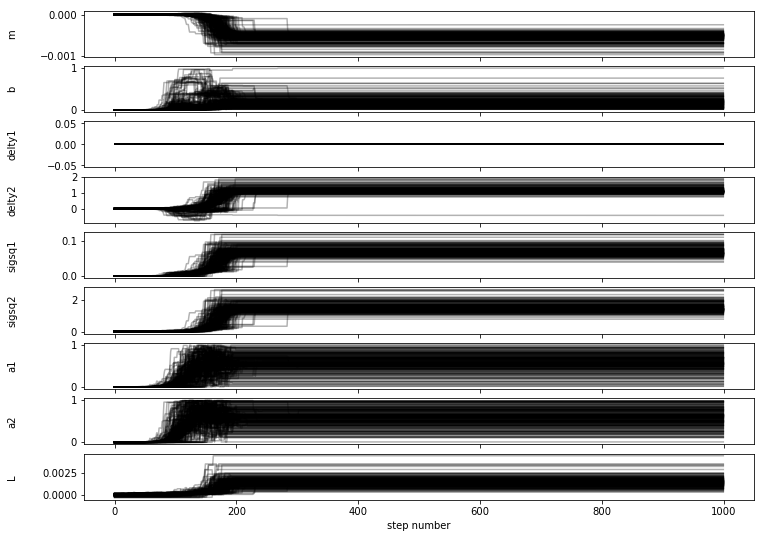

In [183]:
plt.figure(1)
fig, axes = plt.subplots(ndim, figsize=(12, 9), sharex=True)
samples = sampler.chain
labels = ["m", "b", "delty1", "delty2", "sigsq1", "sigsq2", "a1", "a2", "L"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i].T, "k", alpha=0.3)
#     ax.set_xlim(0, len(samples))
    #(nwalkers, nsteps, dim)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
fig.savefig("200walkers_smallinit_a2.0_1000steps_nongauss_noscatter_matrixeq22_L*_final.png")
plt.show()

In [184]:
flat_samples = sampler.chain[:, 200:, :].reshape((-1, ndim))

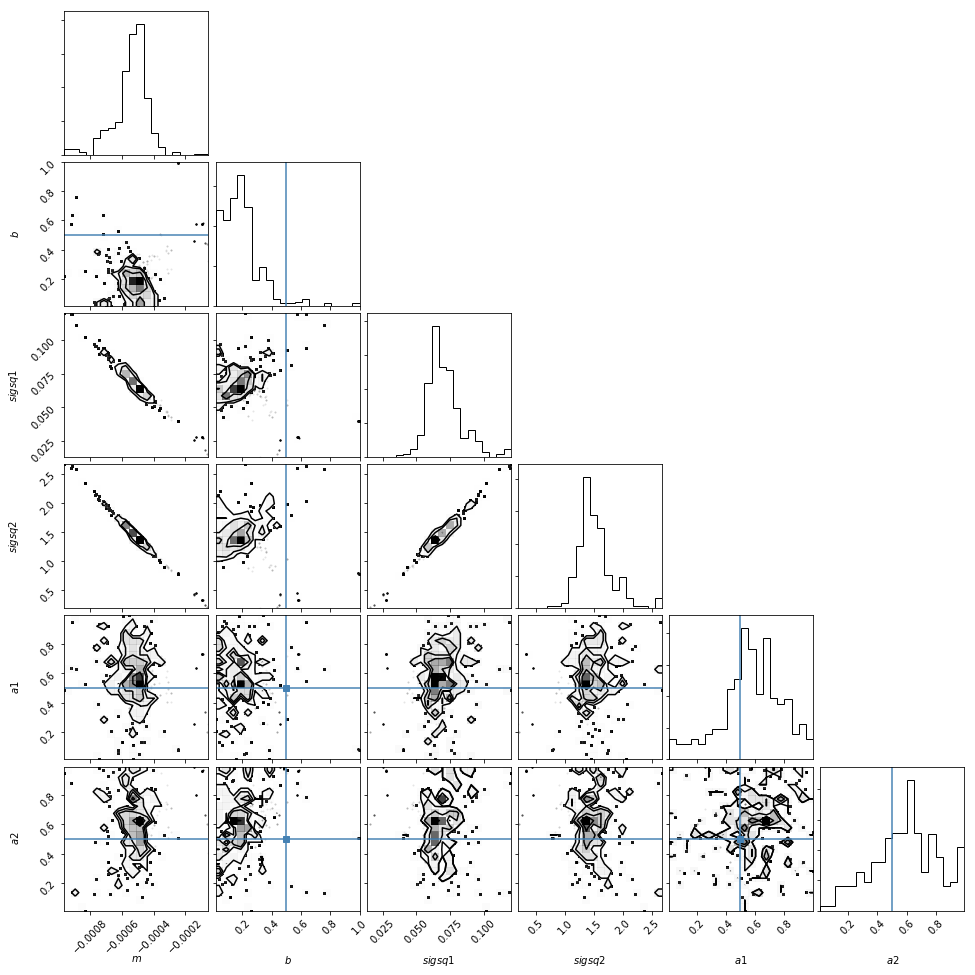

In [185]:
fig = corner.corner(flat_samples[:,[0,1,4,5,6,7]], labels=["$m$", "$b$", "$sigsq1$", "$sigsq2$", "$a1$", "$a2$"],
                      truths=[m_true, b_true, sigsq1_true, sigsq2_true, a1_true, a2_true])
fig.savefig("200walkers_smallinit_a2.0_1000steps_nongauss_noscatter_corner_matrixeq22_L*_final.png")

In [186]:
from IPython.display import display, Math
results = []

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    results.append(mcmc)
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

-0.000522702587624 0.175802266372


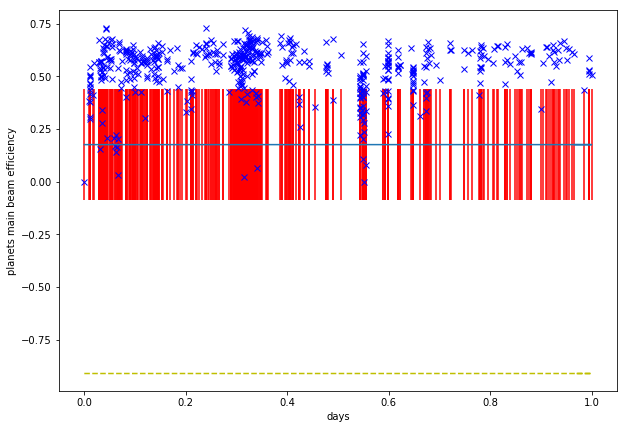

In [187]:
plt.figure(figsize=(10,7))
plt.plot(days, planets_etamb, 'bx')
m = results[0][1]
b = results[1][1]
print(m, b)
y = m*days/1000 + b
yerr = results[4][1]
bias = results[3][1]
plt.xlabel('days')
plt.ylabel('planets main beam efficiency')
plt.errorbar(days, y, yerr=np.sqrt(yerr), ecolor='red')
plt.plot(days, y - bias, '--', color='y')
plt.show()